# 🔍 AML Investigation Agent (Qwen3-30B-A3B-Instruct + DPO)

An autonomous AI Agent for investigating financial transaction graphs to identify money laundering patterns using **Qwen3-30B-A3B-Instruct-2507** (Mixture of Experts) with native Hermes-style tool calling and **Direct Preference Optimization (DPO)** for trajectory-level learning.

## Prerequisites

| Requirement | Minimum | Recommended |
|-------------|---------|-------------|
| **GPU** | 24GB VRAM (RTX 4090) | 40GB+ VRAM (A100/H100) |
| **CUDA** | 12.0+ | 12.4+ |
| **Python** | 3.10+ | 3.12+ |
| **Disk Space** | 30GB (model + data) | 50GB+ |

**Required Packages:**
- `unsloth` (FastModel for MOE models)
- `transformers`, `trl`, `peft` (HuggingFace ecosystem)
- `polars` (data loading)
- `networkx` (graph analysis)
- `mlflow` (observability)
- `google-generativeai` (LLM-as-Judge evaluation)

## Why DPO over GRPO?

Based on research from [Zhang et al. (arXiv:2506.00845)](https://arxiv.org/abs/2506.00845) on graph reasoning with LLMs:

- **GRPO (single-step)**: Optimizes individual actions, but AML investigation requires multi-step reasoning
- **DPO (trajectory-level)**: Compares full successful vs failed investigation trajectories
- **Key finding**: Process-based rewards outperform solution-based by ~24% on graph tasks
- **Practical benefit**: DPO uses offline traces, avoiding expensive online rollouts

## Architecture Overview

| Component | Technology | Description |
|-----------|------------|-------------|
| **Base Model** | Qwen3-30B-A3B-Instruct-2507 | MOE architecture with native tool calling (Hermes format) |
| **Fine-Tuning** | Unsloth FastModel + LoRA | 4-bit quantization, 2x faster training (MOE optimized) |
| **Data Processing** | Polars | High-performance dataframes |
| **Graph Analysis** | NetworkX | Transaction network traversal |
| **Agent Framework** | Custom Agent Loop + State | Stateful exploration with step tracking |
| **Preference Learning** | TRL DPOTrainer | Direct Preference Optimization (trajectory-level) |
| **Observability** | MLflow Tracing | Full agent trace logging |
| **Evaluation** | Gemini LLM-as-Judge | Strategy quality scoring |

## Evaluation Flow

This notebook implements a **three-stage evaluation** to measure training impact:

| Stage | Model State | Purpose |
|-------|-------------|---------|
| **1. Baseline** | Pre-trained Qwen3-30B-A3B-Instruct | Measure zero-shot performance |
| **2. Post-SFT** | After Supervised Fine-Tuning | Measure SFT improvement |
| **3. Post-DPO** | After DPO Training | Measure DPO improvement (trajectory-level) |

## Qwen3 Tool Calling Format (Hermes Style)

Qwen3 uses the Hermes-style tool calling format with `<tool_call>` XML tags:

```
<|im_start|>system
# Tools

You may call one or more functions to assist with the user query.

You are provided with function signatures within <tools></tools> XML tags:
<tools>
{"type": "function", "function": {"name": "tool_name", "description": "...", "parameters": {...}}}
</tools>

For each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:
<tool_call>
{"name": <function-name>, "arguments": <args-json-object>}
</tool_call><|im_end|>
<|im_start|>user
{{user query}}<|im_end|>
<|im_start|>assistant
<tool_call>
{"name": "function_name", "arguments": {"param": "value"}}
</tool_call><|im_end|>
<|im_start|>user
<tool_response>
{"result": "..."}
</tool_response><|im_end|>
```

## Investigation Tools

| Tool | Description |
|------|-------------|
| `get_account_summary` | Get account metadata and risk assessment |
| `get_recent_transactions` | Get top-5 recent transaction flows |
| `check_sanctions_list` | Verify against OFAC watchlist |
| `submit_sar` | Terminal action - Submit Suspicious Activity Report |

## Win Condition
`submit_sar` on an entity that is **both sanctioned AND reachable via a laundering path** from the seed account.

## Known Issues & Troubleshooting

| Issue | Symptom | Solution |
|-------|---------|----------|
| **GPU Driver Crash** | `cudaErrorNotPermitted` or `NVML: Unknown Error` | Restart Docker container or host machine |
| **CUDA OOM** | `CUDA out of memory` | Reduce batch size or `DPO_TRACE_EPISODES` |
| **Quantized Model Error** | `Cannot fine-tune purely quantized models` | Ensure LoRA adapters are attached before training |
| **GPU Not Found** | `Unsloth cannot find any torch accelerator` | Restart container; GPU driver crashed |

**Important**: After collecting DPO traces (inference mode), the GPU requires proper cleanup before training. If CUDA errors occur during training, restart the kernel is not sufficient—restart the container.


## 1. Setup & Configuration

Configure paths, hyperparameters, and training options. Key configuration variables:

| Variable | Description | Default |
|----------|-------------|---------|
| `DATA_DIR` | Path to IBM AML dataset | `data/raw` |
| `MODELS_DIR` | Path to save model adapters | `models` |
| `EVAL_EPISODES` | Number of evaluation episodes per stage | 10 |
| `MAX_STEPS` | Maximum steps per investigation | 20 |
| **SFT Parameters** | | |
| `SFT_EPOCHS` | SFT training epochs | 3 |
| `SFT_LEARNING_RATE` | SFT learning rate | 2e-4 |
| `LORA_R` | LoRA rank | 32 |
| `LORA_ALPHA` | LoRA alpha | 64 |
| **DPO Parameters** | | |
| `DPO_EPOCHS` | DPO training epochs | 2 |
| `DPO_LEARNING_RATE` | DPO learning rate | 5e-6 |
| `DPO_BETA` | KL penalty coefficient | 0.1 |
| `DPO_TRACE_EPISODES` | Episodes to collect for DPO | 30 |
| `RECOMPUTE_DPO_DATASET` | Regenerate DPO pairs or load cached | False |


In [1]:
# ============================================================================
# AML INVESTIGATION AGENT (Qwen3-30B-A3B-Instruct) - Setup & Dependencies
# ============================================================================

# CRITICAL: Import Unsloth FIRST before any other ML libraries
# This ensures all optimizations are applied correctly
# NOTE: For MOE models (like Qwen3-30B-A3B), use FastModel instead of FastLanguageModel
#       See: https://unsloth.ai/docs/models/qwen3-how-to-run-and-fine-tune/qwen3-2507
from unsloth import FastModel

import os
import sys
import json
import random
import time
import re
import uuid
from datetime import datetime
from dataclasses import dataclass, field
from typing import Dict, List, Any, Tuple, Optional, Annotated, Literal, TypedDict
import operator
from pathlib import Path

# Numerical & Data Processing
import numpy as np
import polars as pl
import pandas as pd
import networkx as nx

# ML & Deep Learning (imported AFTER unsloth)
import torch

# Environment
from dotenv import load_dotenv
load_dotenv()

# ============================================================================
# CONFIGURATION
# ============================================================================

# Model Configuration
# Available Qwen3-2507 models (MOE = Mixture of Experts):
#   - "unsloth/Qwen3-4B-Thinking-2507"                    # ~3GB VRAM - Dense, small
#   - "unsloth/Qwen3-30B-A3B-Thinking-2507"               # ~17GB VRAM - MOE (Thinking mode)
#   - "unsloth/Qwen3-30B-A3B-Instruct-2507"               # ~17GB VRAM - MOE (Instruct mode)
#   - "unsloth/Qwen3-235B-A22B-Thinking-2507"             # Multi-GPU - MOE (Thinking mode)
#   - "unsloth/Qwen3-235B-A22B-Instruct-2507"             # Multi-GPU - MOE (Instruct mode)
#
# IMPORTANT: MOE models require FastModel (not FastLanguageModel)
# IMPORTANT: Use Instruct model for faster inference with tool calling
# Instruct models are designed for fast, direct responses with tool calling support
# Thinking models are VERY slow because they generate long reasoning traces
MODEL_NAME = "unsloth/Qwen3-30B-A3B-Instruct-2507"
IS_THINKING_MODEL = "Thinking" in MODEL_NAME  # Auto-detect thinking vs instruct
GEMINI_MODEL = "gemini-2.0-flash"    # LLM-as-Judge

# Qwen3-2507 Recommended Generation Settings (from Unsloth docs)
# https://unsloth.ai/docs/models/qwen3-how-to-run-and-fine-tune/qwen3-2507
if IS_THINKING_MODEL:
    # Thinking model settings
    GENERATION_TEMPERATURE = 0.6
    GENERATION_TOP_P = 0.95
    GENERATION_TOP_K = 20
    GENERATION_MIN_P = 0.0
else:
    # Instruct model settings (recommended for tool calling)
    GENERATION_TEMPERATURE = 0.7
    GENERATION_TOP_P = 0.8
    GENERATION_TOP_K = 20
    GENERATION_MIN_P = 0.0

# Agent Configuration
MAX_STEPS = 50                        # Max steps per investigation
MAX_HISTORY_TURNS = 6                 # Conversation history limit

# Training Configuration - SFT (Supervised Fine-Tuning)
SFT_EPOCHS = 3
SFT_LEARNING_RATE = 2e-4

# Training Configuration - DPO (Direct Preference Optimization)
# DPO uses full episode trajectories to learn preferences between
# successful and failed investigations (trajectory-level learning)
DPO_EPOCHS = 1
DPO_LEARNING_RATE = 5e-7              # Lower LR for DPO stability
DPO_BETA = 0.1                        # KL penalty coefficient (controls deviation from reference model)
DPO_TRACE_EPISODES = 50               # Episodes to collect for DPO training data
DPO_MAX_PAIRS = 100                   # Maximum preference pairs to create
RECOMPUTE_DPO_DATASET = False         # If True, regenerate DPO dataset; if False, use cached if available

# LoRA Configuration
LORA_R = 32                           # Higher rank for complex reasoning
LORA_ALPHA = 64
LORA_TARGET_MODULES = [
    "q_proj", "k_proj", "v_proj", "o_proj",
    "gate_proj", "up_proj", "down_proj"
]

# Evaluation Configuration
EVAL_EPISODES = 10                    # Episodes per evaluation stage

# Random Seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Paths (relative to notebook location)
# Notebook is at: notebooks/agents/aml_investigation_agent_v2.ipynb
# Project root is 2 levels up
NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent  # Go up from notebooks/agents to project root
DATA_DIR = PROJECT_ROOT / "data" / "raw"
MODELS_DIR = PROJECT_ROOT / "models"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

# Ensure directories exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Dataset Selection
DATASET_SIZE = "Small"   # Options: "Small", "Medium", "Large"
DATASET_PREFIX = "LI"    # Options: "LI" (Low Illicit), "HI" (High Illicit)

# ============================================================================
# RESULTS STORAGE - For comparison across training stages
# ============================================================================

evaluation_results = {
    "baseline": None,
    "post_sft": None,
    "post_grpo": None,
}

print("=" * 60)
print("🔍 AML INVESTIGATION AGENT (Qwen3-30B-A3B-Instruct) - Configuration")
print("=" * 60)
print(f"  Model:           {MODEL_NAME}")
print(f"  Judge:           {GEMINI_MODEL}")
print(f"  Dataset:         {DATASET_PREFIX}-{DATASET_SIZE}")
print(f"  Max Steps:       {MAX_STEPS}")
print(f"  Eval Episodes:   {EVAL_EPISODES}")
print(f"  LoRA Rank:       {LORA_R}")
print(f"  LoRA Alpha:      {LORA_ALPHA}")
print(f"  Random Seed:     {RANDOM_SEED}")
print(f"  Project Root:    {PROJECT_ROOT}")
print(f"  Data Dir:        {DATA_DIR}")
print(f"  Models Dir:      {MODELS_DIR}")
print(f"  GPU Available:   {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU Device:      {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory:      {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"  Thinking Model:  {IS_THINKING_MODEL}")
print(f"  Temperature:     {GENERATION_TEMPERATURE}")
print(f"  Top-P:           {GENERATION_TOP_P}")
print(f"  Top-K:           {GENERATION_TOP_K}")
print("=" * 60)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
🔍 AML INVESTIGATION AGENT (Qwen3-30B-A3B-Instruct) - Configuration
  Model:           unsloth/Qwen3-30B-A3B-Instruct-2507
  Judge:           gemini-2.0-flash
  Dataset:         LI-Small
  Max Steps:       50
  Eval Episodes:   10
  LoRA Rank:       32
  LoRA Alpha:      64
  Random Seed:     42
  Project Root:    /workspace
  Data Dir:        /workspace/data/raw
  Models Dir:      /workspace/models
  GPU Available:   True
  GPU Device:      NVIDIA GB10
  GPU Memory:      128.5 GB
  Thinking Model:  False
  Temperature:     0.7
  Top-P:           0.8
  Top-K:           20


## 2. Data Loading with Polars

Download the IBM AML dataset from Kaggle (if not already present) and load using Polars for high-performance data manipulation.

**Dataset**: [IBM Transactions for Anti Money Laundering (AML)](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/data)


In [2]:
# ============================================================================
# DOWNLOAD DATASET FROM KAGGLE - IBM AML Transactions Dataset
# Dataset: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml
# ============================================================================

import zipfile
import shutil

# Kaggle dataset identifier
KAGGLE_DATASET = "ealtman2019/ibm-transactions-for-anti-money-laundering-aml"

# Check if required files exist
trans_file = DATA_DIR / f"{DATASET_PREFIX}-{DATASET_SIZE}_Trans.csv"
accounts_file = DATA_DIR / f"{DATASET_PREFIX}-{DATASET_SIZE}_accounts.csv"
patterns_file = DATA_DIR / f"{DATASET_PREFIX}-{DATASET_SIZE}_Patterns.txt"

files_exist = trans_file.exists() and accounts_file.exists() and patterns_file.exists()

if files_exist:
    print(f"✓ Dataset already exists at {DATA_DIR}")
    print(f"  - Transactions: {trans_file.name}")
    print(f"  - Accounts: {accounts_file.name}")
    print(f"  - Patterns: {patterns_file.name}")
else:
    print(f"📥 Dataset not found. Downloading from Kaggle...")
    print(f"   Dataset: {KAGGLE_DATASET}")
    
    # Ensure data directory exists
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    
    try:
        # Import and authenticate Kaggle API
        from kaggle.api.kaggle_api_extended import KaggleApi
        
        api = KaggleApi()
        api.authenticate()
        
        print(f"   ✓ Kaggle API authenticated")
        
        # Download dataset
        print(f"   Downloading dataset to {DATA_DIR}...")
        api.dataset_download_files(
            dataset=KAGGLE_DATASET,
            path=str(DATA_DIR),
            unzip=True,
            quiet=False
        )
        
        print(f"   ✓ Download complete!")
        
        # List downloaded files
        print(f"\n   Downloaded files:")
        for f in sorted(DATA_DIR.glob("*")):
            size_mb = f.stat().st_size / (1024 * 1024)
            print(f"     - {f.name} ({size_mb:.1f} MB)")
        
    except ImportError:
        print("   ❌ Kaggle package not installed.")
        print("   Run: pip install kaggle")
        print("   Then set up ~/.kaggle/kaggle.json with your API credentials")
        raise ImportError("Please install kaggle package: pip install kaggle")
        
    except Exception as e:
        print(f"   ❌ Error downloading dataset: {e}")
        print("\n   Manual download instructions:")
        print(f"   1. Visit: https://www.kaggle.com/datasets/{KAGGLE_DATASET}")
        print(f"   2. Download and extract to: {DATA_DIR}")
        raise

# Verify files exist after download
assert trans_file.exists(), f"Transaction file not found: {trans_file}"
assert accounts_file.exists(), f"Accounts file not found: {accounts_file}"
assert patterns_file.exists(), f"Patterns file not found: {patterns_file}"

print(f"\n{'=' * 60}")
print(f"✓ DATASET READY: {DATASET_PREFIX}-{DATASET_SIZE}")
print(f"{'=' * 60}")


✓ Dataset already exists at /workspace/data/raw
  - Transactions: LI-Small_Trans.csv
  - Accounts: LI-Small_accounts.csv
  - Patterns: LI-Small_Patterns.txt

✓ DATASET READY: LI-Small


In [3]:
# ============================================================================
# DATA LOADING - IBM AML Dataset with Polars
# ============================================================================
# FIX: The transactions file has LEADING ZEROS on bank IDs (e.g., "001120")
# but the accounts file stores them without (e.g., "1120"). We normalize by
# casting bank IDs to Int64 first, which strips leading zeros.

print("📊 Loading IBM AML Dataset with Polars...")

# Load transactions
raw_trans_pl = pl.read_csv(
    trans_file,
    new_columns=[
        'timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
        'amount_received', 'receiving_currency', 'amount_paid',
        'payment_currency', 'payment_format', 'is_laundering'
    ],
    skip_rows=1
)
print(f"✓ Loaded {len(raw_trans_pl):,} transactions")

# Load accounts
raw_accounts_pl = pl.read_csv(accounts_file)
print(f"✓ Loaded {len(raw_accounts_pl):,} accounts")

# Process transactions - Create unique account IDs
# CRITICAL FIX: Cast bank IDs to Int64 first to remove leading zeros, then to Utf8
transactions_pl = raw_trans_pl.with_columns([
    (pl.col('from_bank').cast(pl.Int64).cast(pl.Utf8) + '-' + pl.col('from_account').cast(pl.Utf8)).alias('from_account_id'),
    (pl.col('to_bank').cast(pl.Int64).cast(pl.Utf8) + '-' + pl.col('to_account').cast(pl.Utf8)).alias('to_account_id'),
    (pl.lit('TXN-') + pl.arange(0, pl.len()).cast(pl.Utf8)).alias('transaction_id'),
    pl.col('is_laundering').cast(pl.Int32),
]).select([
    'transaction_id',
    pl.col('from_account_id').alias('from_account'),
    pl.col('to_account_id').alias('to_account'),
    pl.col('amount_received').alias('amount'),
    pl.col('receiving_currency').alias('currency'),
    'timestamp', 'is_laundering', 'payment_format',
])

# Identify laundering destinations for sanctioned marking
laundering_dests = set(
    transactions_pl.filter(pl.col('is_laundering') == 1)['to_account'].unique().to_list()
)
print(f"✓ Found {len(laundering_dests):,} laundering destination accounts")

# Process accounts - Add risk scores and sanctioned flags
# Bank ID in accounts file is already without leading zeros, so just cast to Utf8
accounts_pl = raw_accounts_pl.rename({
    'Bank Name': 'bank_name', 'Bank ID': 'bank_id',
    'Account Number': 'account_number', 'Entity ID': 'entity_id', 'Entity Name': 'entity_name'
}).with_columns([
    (pl.col('bank_id').cast(pl.Utf8) + '-' + pl.col('account_number').cast(pl.Utf8)).alias('account_id'),
    pl.when(pl.col('entity_name').str.contains('Corporation')).then(pl.lit('Corporate'))
        .when(pl.col('entity_name').str.contains('Partnership')).then(pl.lit('Partnership'))
        .when(pl.col('entity_name').str.contains('Sole Proprietorship')).then(pl.lit('Individual'))
        .otherwise(pl.lit('Unknown')).alias('account_type'),
])

# Add sanctioned flag (30% of laundering destinations) and risk scores
account_ids = accounts_pl['account_id'].to_list()
accounts_pl = accounts_pl.with_columns([
    pl.Series('is_sanctioned', [acc in laundering_dests and random.random() < 0.3 for acc in account_ids]),
    pl.Series('risk_score', [round(random.uniform(0.1, 0.9), 2) for _ in range(len(account_ids))]),
]).select(['account_id', 'bank_id', 'bank_name', 'entity_id', 'entity_name', 'account_type', 'risk_score', 'is_sanctioned'])

# Convert to pandas for NetworkX
transactions_df = transactions_pl.to_pandas()
accounts_df = accounts_pl.to_pandas()

# Summary
n_accounts, n_transactions = len(accounts_df), len(transactions_df)
n_laundering = int(transactions_df['is_laundering'].sum())
n_sanctioned = int(accounts_df['is_sanctioned'].sum())

print(f"\n{'=' * 60}")
print(f"📊 DATASET SUMMARY: {DATASET_PREFIX}-{DATASET_SIZE}")
print(f"{'=' * 60}")
print(f"  Accounts:             {n_accounts:>12,}")
print(f"  Transactions:         {n_transactions:>12,}")
print(f"  Laundering Txns:      {n_laundering:>12,} ({n_laundering/n_transactions*100:.2f}%)")
print(f"  Sanctioned Accounts:  {n_sanctioned:>12,}")
print(f"  Laundering Dests:     {len(laundering_dests):>12,}")
print(f"{'=' * 60}")


📊 Loading IBM AML Dataset with Polars...
✓ Loaded 6,924,048 transactions
✓ Loaded 712,688 accounts
✓ Found 3,304 laundering destination accounts

📊 DATASET SUMMARY: LI-Small
  Accounts:                  712,688
  Transactions:            6,924,048
  Laundering Txns:             3,565 (0.05%)
  Sanctioned Accounts:           975
  Laundering Dests:            3,304


In [4]:
# ============================================================================
# PARSE LAUNDERING PATTERNS - Extract Pattern Seeds for Training
# ============================================================================

@dataclass
class LaunderingPattern:
    """Represents a single money laundering pattern from the dataset."""
    pattern_type: str
    pattern_info: str
    transactions: List[dict]
    accounts_involved: set
    
    @property
    def seed_account(self) -> str:
        return self.transactions[0].get('from_account', '') if self.transactions else ''
    
    @property
    def terminal_account(self) -> str:
        return self.transactions[-1].get('to_account', '') if self.transactions else ''
    
    @property
    def total_amount(self) -> float:
        return sum(t.get('amount', 0) for t in self.transactions)
    
    @property
    def hop_count(self) -> int:
        return len(self.transactions)


def parse_patterns_file(filepath: Path) -> List[LaunderingPattern]:
    """Parse patterns file to extract laundering patterns."""
    patterns = []
    current_pattern = None
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            
            if line.startswith('BEGIN LAUNDERING ATTEMPT'):
                match = re.match(r'BEGIN LAUNDERING ATTEMPT - (\w+(?:-\w+)?):?\s*(.*)', line)
                if match:
                    current_pattern = LaunderingPattern(
                        pattern_type=match.group(1),
                        pattern_info=match.group(2).strip() if match.group(2) else "",
                        transactions=[], accounts_involved=set()
                    )
            
            elif line.startswith('END LAUNDERING ATTEMPT'):
                if current_pattern and current_pattern.transactions:
                    patterns.append(current_pattern)
                current_pattern = None
            
            elif current_pattern and line and not line.startswith('BEGIN') and not line.startswith('END'):
                parts = line.split(',')
                if len(parts) >= 7:
                    try:
                        # CRITICAL FIX: Normalize bank IDs by converting to int first
                        # This removes leading zeros (e.g., "001120" -> "1120")
                        from_bank = str(int(parts[1].strip()))
                        to_bank = str(int(parts[3].strip()))
                        from_account = f"{from_bank}-{parts[2].strip()}"
                        to_account = f"{to_bank}-{parts[4].strip()}"
                        amount = float(parts[5].strip())
                        
                        current_pattern.transactions.append({
                            'timestamp': parts[0].strip(),
                            'from_account': from_account, 'to_account': to_account,
                            'amount': amount, 'currency': parts[6].strip(),
                        })
                        current_pattern.accounts_involved.add(from_account)
                        current_pattern.accounts_involved.add(to_account)
                    except (ValueError, IndexError):
                        pass
    
    return patterns


# Parse patterns
laundering_patterns = parse_patterns_file(patterns_file)

# Statistics
pattern_types = {}
for p in laundering_patterns:
    pattern_types[p.pattern_type] = pattern_types.get(p.pattern_type, 0) + 1

print(f"\n{'=' * 60}")
print(f"🔗 LAUNDERING PATTERNS PARSED")
print(f"{'=' * 60}")
print(f"  Total Patterns: {len(laundering_patterns):,}")
for ptype, count in sorted(pattern_types.items(), key=lambda x: -x[1]):
    print(f"    - {ptype:<20} {count:>6,}")
print(f"{'=' * 60}")



🔗 LAUNDERING PATTERNS PARSED
  Total Patterns: 117
    - FAN-OUT                  19
    - STACK                    18
    - BIPARTITE                16
    - RANDOM                   15
    - SCATTER-GATHER           13
    - FAN-IN                   12
    - GATHER-SCATTER           12
    - CYCLE                    12


## 3. Financial Environment with MLflow-Instrumented Tools

Build the transaction graph with NetworkX and create the `FinancialEnvironment` class with MLflow-traced tool functions.

**Key Implementation Details:**

| Feature | Description |
|---------|-------------|
| **Account ID Normalization** | Account IDs are normalized to `{Bank_ID}_{Account_Number}` format with leading zeros preserved (e.g., `0012_12345678`) to ensure consistency between transaction and account files |
| **Transaction Graph** | Directed graph where nodes are accounts and edges are transactions with `is_laundering` attribute |
| **Sanctions List** | 30% of accounts are randomly marked as sanctioned for training purposes |
| **MLflow Tracing** | All tool calls are automatically logged for observability |

**Tool Implementations:**
- Return JSON-serializable dictionaries compatible with Qwen3's Hermes-style tool calling format
- Include risk scores and laundering edge detection for strategic decision-making


In [5]:
# ============================================================================
# FINANCIAL ENVIRONMENT - NetworkX Graph with MLflow-Traced Tools
# ============================================================================

import mlflow

mlflow.set_experiment("AML_Investigation_Agent_v2")
print("✓ MLflow experiment: AML_Investigation_Agent_v2")


@dataclass 
class FinancialEnvironment:
    """Financial investigation environment with path-validated SAR evaluation."""
    graph: nx.DiGraph = field(default_factory=nx.DiGraph)
    accounts: Dict[str, dict] = field(default_factory=dict)
    laundering_targets: List[str] = field(default_factory=list)
    all_sanctioned: set = field(default_factory=set)
    laundering_destinations: set = field(default_factory=set)
    transitive_illicit: set = field(default_factory=set)
    current_start_account: str = ""
    
    @classmethod
    def from_dataframes(cls, transactions_df: pd.DataFrame, accounts_df: pd.DataFrame) -> 'FinancialEnvironment':
        env = cls()
        
        for _, row in accounts_df.iterrows():
            env.accounts[row['account_id']] = row.to_dict()
            env.graph.add_node(row['account_id'], **row.to_dict())
        
        for _, row in transactions_df.iterrows():
            env.graph.add_edge(
                row['from_account'], row['to_account'],
                transaction_id=row['transaction_id'], amount=row['amount'],
                currency=row.get('currency', 'USD'), timestamp=row['timestamp'],
                is_laundering=row['is_laundering']
            )
        
        env.all_sanctioned = set(accounts_df[accounts_df['is_sanctioned']]['account_id'])
        laundering_txns = transactions_df[transactions_df['is_laundering'] == 1]
        env.laundering_destinations = set(laundering_txns['to_account'].unique())
        env._compute_transitive_illicit()
        env.laundering_targets = list(env.all_sanctioned & env.laundering_destinations)
        
        return env
    
    def _compute_transitive_illicit(self):
        self.transitive_illicit = set()
        laundering_sources = set()
        for u, v, data in self.graph.edges(data=True):
            if data.get('is_laundering', 0) == 1:
                laundering_sources.add(u)
                self.transitive_illicit.add(u)
                self.transitive_illicit.add(v)
        
        for source in laundering_sources:
            visited = {source}
            queue = [source]
            while queue:
                node = queue.pop(0)
                for neighbor in self.graph.successors(node):
                    edge_data = self.graph.edges[node, neighbor]
                    if edge_data.get('is_laundering', 0) == 1 and neighbor not in visited:
                        visited.add(neighbor)
                        self.transitive_illicit.add(neighbor)
                        queue.append(neighbor)
    
    def is_on_laundering_path(self, entity_id: str, max_depth: int = 10) -> bool:
        if not self.current_start_account:
            return False
        try:
            for path in nx.all_simple_paths(self.graph, self.current_start_account, entity_id, cutoff=max_depth):
                if all(self.graph.edges[path[i], path[i+1]].get('is_laundering', 0) == 1 for i in range(len(path)-1)):
                    return True
            return False
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return False
    
    @mlflow.trace(span_type="TOOL")
    def get_account_summary(self, account_id: str) -> dict:
        if account_id not in self.accounts:
            return {"error": f"Account {account_id} not found"}
        acc = self.accounts[account_id]
        return {
            "account_id": account_id, "account_type": acc.get('account_type', 'Unknown'),
            "entity_name": acc.get('entity_name', 'Unknown'), "bank_name": acc.get('bank_name', 'Unknown'),
            "risk_score": round(acc.get('risk_score', 0), 2), "is_sanctioned": acc.get('is_sanctioned', False),
            "transitive_illicit": account_id in self.transitive_illicit,
        }
    
    @mlflow.trace(span_type="TOOL")
    def get_recent_transactions(self, account_id: str, direction: str = "outgoing", limit: int = 5) -> List[dict]:
        if account_id not in self.graph:
            return []
        edges = list(self.graph.out_edges(account_id, data=True) if direction == "outgoing" 
                     else self.graph.in_edges(account_id, data=True))
        edges = sorted(edges, key=lambda e: e[2].get('amount', 0), reverse=True)[:limit]
        
        results = []
        for edge in edges:
            target = edge[1] if direction == "outgoing" else edge[0]
            results.append({
                "counterparty": target, "amount": round(edge[2].get('amount', 0), 2),
                "currency": edge[2].get('currency', 'USD'), "is_laundering": edge[2].get('is_laundering', 0),
                "high_risk_indicator": target in self.transitive_illicit,
            })
        return results
    
    @mlflow.trace(span_type="TOOL")
    def check_sanctions_list(self, entity_id: str) -> dict:
        is_sanctioned = entity_id in self.all_sanctioned
        return {"entity_id": entity_id, "on_sanctions_list": is_sanctioned, "list_type": "OFAC SDN" if is_sanctioned else None}
    
    @mlflow.trace(span_type="TOOL")
    def submit_sar(self, entity_id: str, reason: str) -> dict:
        is_sanctioned = entity_id in self.all_sanctioned
        is_primary = entity_id in self.laundering_targets
        on_path = self.is_on_laundering_path(entity_id)
        correct = is_primary or (is_sanctioned and on_path)
        
        if is_primary:
            eval_reason = "PRIMARY_TARGET: sanctioned + receives laundering directly"
        elif is_sanctioned and on_path:
            eval_reason = f"VALID: sanctioned + on laundering path from {self.current_start_account}"
        elif is_sanctioned:
            eval_reason = "INVALID: sanctioned but NOT on laundering path from start"
        else:
            eval_reason = "INVALID: entity is not sanctioned"
        
        return {
            "entity_id": entity_id, "reason": reason, "report_id": f"SAR-{uuid.uuid4().hex[:8].upper()}",
            "correct_identification": correct, "is_sanctioned": is_sanctioned,
            "is_primary_target": is_primary, "on_laundering_path": on_path, "evaluation_reason": eval_reason,
        }
    
    def reset_investigation(self, start_account: str):
        self.current_start_account = start_account


# Build environment
env = FinancialEnvironment.from_dataframes(transactions_df, accounts_df)

print(f"\n{'=' * 60}")
print(f"🏦 FINANCIAL ENVIRONMENT BUILT")
print(f"{'=' * 60}")
print(f"  Graph Nodes:          {env.graph.number_of_nodes():>12,}")
print(f"  Graph Edges:          {env.graph.number_of_edges():>12,}")
print(f"  Sanctioned Accounts:  {len(env.all_sanctioned):>12,}")
print(f"  Primary Targets:      {len(env.laundering_targets):>12,}")
print(f"  Transitive Illicit:   {len(env.transitive_illicit):>12,}")
print(f"{'=' * 60}")


✓ MLflow experiment: AML_Investigation_Agent_v2


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)



🏦 FINANCIAL ENVIRONMENT BUILT
  Graph Nodes:               712,688
  Graph Edges:             1,384,862
  Sanctioned Accounts:           975
  Primary Targets:               975
  Transitive Illicit:          4,173


## 3.1 Data Verification: Pattern Reachability

Verify that laundering patterns lead to sanctioned entities that the agent can discover. This is critical for evaluating agent success rates.

**Key Metrics:**
- **Laundering destination coverage**: Do destination accounts from transactions exist in the accounts file?
- **Pattern reachability**: What % of patterns have at least one sanctioned entity reachable via `is_laundering=1` edges?
- **Primary targets**: The intersection of sanctioned accounts and laundering destinations


In [6]:
# ============================================================================
# DATA VERIFICATION: Check if patterns lead to sanctioned entities
# ============================================================================

print("=" * 70)
print("🔍 VERIFICATION: Can agents reach sanctioned entities from seeds?")
print("=" * 70)

# Check 1: How many laundering destinations exist in accounts_df?
all_account_ids = set(accounts_df['account_id'])
laund_dests_in_accounts = laundering_dests & all_account_ids
laund_dests_missing = laundering_dests - all_account_ids

print(f"\n📊 Laundering Destination Coverage:")
print(f"  Total laundering destinations:    {len(laundering_dests):,}")
print(f"  Found in accounts_df:             {len(laund_dests_in_accounts):,} ({100*len(laund_dests_in_accounts)/len(laundering_dests):.1f}%)")
print(f"  Missing from accounts_df:         {len(laund_dests_missing):,}")

# Helper: Get all destination accounts from a pattern (not just the last one)
def get_pattern_destinations(pattern):
    """Get all destination accounts from pattern transactions."""
    return list(set(t.get('to_account', '') for t in pattern.transactions if t.get('to_account')))

# Check 2: How many patterns have at least one reachable sanctioned entity?
patterns_with_sanctioned = 0
patterns_without_sanctioned = 0
patterns_with_missing_terminals = 0
valid_patterns = []  # Patterns with at least one reachable sanctioned entity

for pattern in laundering_patterns:
    # Get all destination accounts in this pattern
    terminals = get_pattern_destinations(pattern)
    terminals_in_accounts = [t for t in terminals if t in all_account_ids]
    terminals_sanctioned = [t for t in terminals if t in env.all_sanctioned]
    
    if len(terminals) > len(terminals_in_accounts):
        patterns_with_missing_terminals += 1
    
    # Check if any terminal is reachable via laundering path
    seed = pattern.seed_account
    reachable_sanctioned = []
    if seed in env.graph:
        for t in terminals_sanctioned:
            if t in env.graph:
                try:
                    for path in nx.all_simple_paths(env.graph, seed, t, cutoff=15):
                        if all(env.graph.edges[path[j], path[j+1]].get('is_laundering', 0) == 1 
                               for j in range(len(path)-1)):
                            reachable_sanctioned.append(t)
                            break
                except:
                    pass
    
    if reachable_sanctioned:
        patterns_with_sanctioned += 1
        valid_patterns.append(pattern)
    else:
        patterns_without_sanctioned += 1

print(f"\n📊 Pattern Reachability to Sanctioned Entities:")
print(f"  Total patterns:                   {len(laundering_patterns):,}")
print(f"  Patterns with ≥1 sanctioned:      {patterns_with_sanctioned:,} ({100*patterns_with_sanctioned/len(laundering_patterns):.1f}%)")
print(f"  Patterns with 0 sanctioned:       {patterns_without_sanctioned:,} ({100*patterns_without_sanctioned/len(laundering_patterns):.1f}%)")
print(f"  Patterns with missing terminals:  {patterns_with_missing_terminals:,}")

# Check 3: Primary targets (intersection)
print(f"\n📊 Primary Targets (sanctioned ∩ laundering_destinations):")
print(f"  Total sanctioned accounts:        {len(env.all_sanctioned):,}")
print(f"  Total laundering destinations:    {len(env.laundering_destinations):,}")
print(f"  Primary targets (intersection):   {len(env.laundering_targets):,}")

# Check 4: Sample verification for a few patterns
print(f"\n📋 Sample Pattern Analysis (first 5):")
for i, pattern in enumerate(laundering_patterns[:5]):
    seed = pattern.seed_account
    terminals = get_pattern_destinations(pattern)
    
    # Check if seed exists
    seed_exists = seed in env.accounts
    seed_in_graph = seed in env.graph
    
    # Check terminals
    terminals_sanctioned = [t for t in terminals if t in env.all_sanctioned]
    terminals_in_accounts = [t for t in terminals if t in env.accounts]
    
    # Check reachability via is_laundering=1 path
    reachable_sanctioned = []
    if seed_in_graph:
        for t in terminals_sanctioned:
            if t in env.graph:
                try:
                    for path in nx.all_simple_paths(env.graph, seed, t, cutoff=15):
                        if all(env.graph.edges[path[j], path[j+1]].get('is_laundering', 0) == 1 
                               for j in range(len(path)-1)):
                            reachable_sanctioned.append(t)
                            break
                except:
                    pass
    
    status = "✅" if reachable_sanctioned else "❌"
    print(f"\n  Pattern {i+1} ({pattern.pattern_type}):")
    print(f"    Seed: {seed} (in accounts: {seed_exists}, in graph: {seed_in_graph})")
    print(f"    Terminals: {len(terminals)} total, {len(terminals_in_accounts)} in accounts, {len(terminals_sanctioned)} sanctioned")
    print(f"    Reachable sanctioned: {len(reachable_sanctioned)} {status}")

# Store valid patterns for later use
print(f"\n{'=' * 70}")
print(f"📌 RECOMMENDATION:")
if patterns_with_sanctioned / len(laundering_patterns) < 0.5:
    print(f"   ⚠️  Only {100*patterns_with_sanctioned/len(laundering_patterns):.1f}% of patterns have reachable sanctioned entities.")
    print(f"   Consider using 'valid_patterns' ({len(valid_patterns)}) for evaluation instead of all patterns.")
    print(f"   This ensures the agent CAN succeed if it follows the correct strategy.")
else:
    print(f"   ✅ {100*patterns_with_sanctioned/len(laundering_patterns):.1f}% of patterns have reachable sanctioned entities.")
    print(f"   Pattern coverage is sufficient for training and evaluation.")
print(f"{'=' * 70}")


🔍 VERIFICATION: Can agents reach sanctioned entities from seeds?

📊 Laundering Destination Coverage:
  Total laundering destinations:    3,304
  Found in accounts_df:             3,304 (100.0%)
  Missing from accounts_df:         0

📊 Pattern Reachability to Sanctioned Entities:
  Total patterns:                   117
  Patterns with ≥1 sanctioned:      72 (61.5%)
  Patterns with 0 sanctioned:       45 (38.5%)
  Patterns with missing terminals:  0

📊 Primary Targets (sanctioned ∩ laundering_destinations):
  Total sanctioned accounts:        975
  Total laundering destinations:    3,304
  Primary targets (intersection):   975

📋 Sample Pattern Analysis (first 5):

  Pattern 1 (FAN-IN):
    Seed: 1812-80279F810 (in accounts: True, in graph: True)
    Terminals: 1 total, 1 in accounts, 0 sanctioned
    Reachable sanctioned: 0 ❌

  Pattern 2 (FAN-IN):
    Seed: 3671-801BF8E70 (in accounts: True, in graph: True)
    Terminals: 1 total, 1 in accounts, 0 sanctioned
    Reachable sanctioned: 0

## 3.2 Training Needs Assessment

Before investing in fine-tuning, we should understand **what problems we're solving**:

| Training Stage | Purpose | When Needed |
|----------------|---------|-------------|
| **No Training** | Use base Qwen3 instruct model | If base model already achieves >70% success with correct tool format |
| **SFT Only** | Teach tool format + basic strategy | If model struggles with tool calling syntax or basic reasoning |
| **DPO Only** | Optimize decision-making with trajectory preferences | If model uses tools correctly but makes poor strategic choices |
| **SFT + DPO** | Full pipeline | If both format AND strategy improvements are needed |

**Decision Framework:**
1. Run baseline evaluation on `valid_patterns`
2. Analyze failure modes:
   - **Format errors**: Wrong tool call syntax → Needs SFT
   - **Wrong tool choice**: Correct syntax but poor decisions → Needs DPO
   - **Premature SAR**: Files SAR without checking sanctions → Needs both
   - **Gets stuck**: Doesn't progress investigation → Needs DPO


In [7]:
# ============================================================================
# TRAINING NEEDS ASSESSMENT - Analyze baseline to determine training strategy
# ============================================================================

def analyze_training_needs(episodes: List['InvestigationEpisode']) -> dict:
    """
    Analyze baseline evaluation results to determine what training is needed.
    
    Returns dict with:
    - needs_sft: bool - whether SFT training would help
    - needs_dpo: bool - whether DPO training would help  
    - failure_analysis: dict - breakdown of failure modes
    - recommendation: str - suggested training approach
    """
    if not episodes:
        return {"error": "No episodes to analyze"}
    
    # Initialize counters
    total = len(episodes)
    successes = sum(1 for e in episodes if e.success)
    
    # Failure mode analysis
    format_errors = 0      # Failed to generate valid tool calls
    wrong_tool_choice = 0  # Valid format but chose wrong tool
    premature_sar = 0      # Filed SAR without checking sanctions
    no_progress = 0        # Got stuck, didn't explore graph
    missed_target = 0      # Explored correctly but missed sanctioned entity
    
    for episode in episodes:
        if episode.success:
            continue
            
        steps = episode.steps
        if not steps:
            no_progress += 1
            continue
        
        # Count tool usage
        tool_counts = {}
        has_format_error = False
        filed_sar = False
        checked_sanctions = False
        explored_transactions = False
        
        for step in steps:
            tool_name = step.get('tool_name', '')
            result = step.get('result', {})
            
            if tool_name == 'fallback':
                has_format_error = True
            elif tool_name:
                tool_counts[tool_name] = tool_counts.get(tool_name, 0) + 1
                
                if tool_name == 'submit_sar':
                    filed_sar = True
                elif tool_name == 'check_sanctions_list':
                    checked_sanctions = True
                elif tool_name == 'get_recent_transactions':
                    explored_transactions = True
        
        # Classify failure mode
        if has_format_error and len(steps) < 3:
            format_errors += 1
        elif filed_sar and not checked_sanctions:
            premature_sar += 1
        elif not explored_transactions:
            no_progress += 1
        elif checked_sanctions and explored_transactions:
            missed_target += 1  # Did everything right but still failed
        else:
            wrong_tool_choice += 1
    
    # Calculate rates
    success_rate = successes / total if total > 0 else 0
    format_error_rate = format_errors / total if total > 0 else 0
    strategy_error_rate = (wrong_tool_choice + premature_sar + no_progress) / total if total > 0 else 0
    
    # Determine training needs
    needs_sft = format_error_rate > 0.1 or premature_sar > 0  # >10% format issues or premature SARs
    needs_dpo = strategy_error_rate > 0.2 or missed_target > 0  # >20% strategy issues
    
    # Generate recommendation
    if success_rate >= 0.7:
        recommendation = "NO_TRAINING - Base model performs well (≥70% success), DPO optional"
    elif needs_sft and needs_dpo:
        recommendation = "SFT_THEN_DPO - Both format and strategy improvements needed"
    elif needs_sft:
        recommendation = "SFT_ONLY - Tool calling format improvements needed"
    elif needs_dpo:
        recommendation = "DPO_ONLY - Strategic decision-making improvements needed"
    else:
        recommendation = "SFT_THEN_DPO - Default full training pipeline"
    
    return {
        "total_episodes": total,
        "success_rate": success_rate,
        "needs_sft": needs_sft,
        "needs_dpo": needs_dpo,
        "failure_analysis": {
            "format_errors": format_errors,
            "wrong_tool_choice": wrong_tool_choice,
            "premature_sar": premature_sar,
            "no_progress": no_progress,
            "missed_target": missed_target,
        },
        "recommendation": recommendation,
    }


def print_training_assessment(analysis: dict):
    """Pretty print the training needs assessment."""
    print(f"\n{'=' * 70}")
    print(f"📋 TRAINING NEEDS ASSESSMENT")
    print(f"{'=' * 70}")
    
    print(f"\n📊 Baseline Performance:")
    print(f"  Success Rate: {analysis['success_rate']*100:.1f}%")
    print(f"  Total Episodes: {analysis['total_episodes']}")
    
    fa = analysis['failure_analysis']
    print(f"\n❌ Failure Mode Breakdown:")
    print(f"  Format Errors:      {fa['format_errors']:3d}  (tool call syntax issues)")
    print(f"  Wrong Tool Choice:  {fa['wrong_tool_choice']:3d}  (correct syntax, poor decisions)")
    print(f"  Premature SAR:      {fa['premature_sar']:3d}  (filed SAR without sanctions check)")
    print(f"  No Progress:        {fa['no_progress']:3d}  (got stuck, didn't explore)")
    print(f"  Missed Target:      {fa['missed_target']:3d}  (explored well but missed entity)")
    
    print(f"\n🎯 Training Recommendation:")
    print(f"  Needs SFT: {'YES' if analysis['needs_sft'] else 'NO'}")
    print(f"  Needs DPO: {'YES' if analysis['needs_dpo'] else 'NO'}")
    print(f"\n  → {analysis['recommendation']}")
    
    # Provide actionable guidance
    print(f"\n📌 Action Items:")
    if "NO_TRAINING" in analysis['recommendation']:
        print(f"  1. Base model is sufficient - proceed to deployment")
        print(f"  2. Consider DPO for further optimization (optional)")
    elif "SFT" in analysis['recommendation']:
        print(f"  1. Run SFT training to teach Qwen3 Hermes-style tool calling")
        print(f"  2. SFT will fix format errors and teach basic investigation flow")
    if "DPO" in analysis['recommendation']:
        print(f"  3. Run DPO training to optimize strategic decisions")
        print(f"  4. DPO will learn from successful/failed trajectories when to explore vs. submit SAR")
    
    print(f"{'=' * 70}")


# Store function for use after baseline evaluation
print("✓ Training needs assessment functions defined")
print("  - analyze_training_needs(episodes): Analyze failure modes")
print("  - print_training_assessment(analysis): Display recommendations")


✓ Training needs assessment functions defined
  - analyze_training_needs(episodes): Analyze failure modes
  - print_training_assessment(analysis): Display recommendations


## 4. Qwen3 Tool Calling Format (Hermes Style)

Implement Qwen3's native Hermes-style tool calling format using `<tool_call>` XML tags.

**Key Features:**
- Tool definitions use OpenAI-compatible JSON Schema format
- Tool calls are wrapped in `<tool_call></tool_call>` tags  
- Tool responses are wrapped in `<tool_response></tool_response>` tags
- Uses `apply_chat_template` with `tools` parameter for proper formatting
- Supports parallel and multi-turn tool calling


In [8]:
# ============================================================================
# QWEN3 TOOL CALLING FORMAT (Hermes Style)
# Ref: https://qwen.readthedocs.io/en/latest/getting_started/concepts.html#tool-calling
# Ref: https://github.com/NousResearch/Hermes-Function-Calling
# ============================================================================

# Define tools in OpenAI-compatible JSON Schema format (used by apply_chat_template)
QWEN3_TOOLS = [
    {
        "type": "function",
        "function": {
            "name": "get_account_summary",
            "description": "Get account metadata and risk assessment for an account ID.",
            "parameters": {
                "type": "object",
                "properties": {
                    "account_id": {
                        "type": "string",
                        "description": "The unique account identifier (format: 'bankid-accountnumber')"
                    }
                },
                "required": ["account_id"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_recent_transactions",
            "description": "Get the top-5 recent transactions by amount for an account.",
            "parameters": {
                "type": "object",
                "properties": {
                    "account_id": {
                        "type": "string",
                        "description": "The account to get transactions for"
                    },
                    "direction": {
                        "type": "string",
                        "enum": ["outgoing", "incoming"],
                        "description": "Transaction direction. Defaults to 'outgoing'"
                    }
                },
                "required": ["account_id"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "check_sanctions_list",
            "description": "Check if an entity is on the OFAC sanctions list. ALWAYS call this before submitting SAR!",
            "parameters": {
                "type": "object",
                "properties": {
                    "entity_id": {
                        "type": "string",
                        "description": "The account/entity ID to check against sanctions"
                    }
                },
                "required": ["entity_id"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "submit_sar",
            "description": "Submit a Suspicious Activity Report. THIS IS A TERMINAL ACTION. Only call after confirming entity is on sanctions list!",
            "parameters": {
                "type": "object",
                "properties": {
                    "entity_id": {
                        "type": "string",
                        "description": "The sanctioned entity to report"
                    },
                    "reason": {
                        "type": "string",
                        "description": "Detailed justification for the SAR submission"
                    }
                },
                "required": ["entity_id", "reason"]
            }
        }
    }
]

# Investigation system prompt for Qwen3
INVESTIGATION_SYSTEM_PROMPT = """You are an expert AML (Anti-Money Laundering) investigator. Your task is to investigate financial transaction networks to identify money laundering patterns.

## INVESTIGATION STRATEGY
1. **START**: Get account summary of the seed account to understand its risk profile
2. **EXPLORE**: Get recent transactions to find money flows and counterparties  
3. **FOLLOW**: Investigate high-amount and high-risk counterparties
4. **VERIFY**: Check sanctions list for suspicious entities BEFORE reporting
5. **REPORT**: Submit SAR ONLY after confirming sanctioned status

## IMPORTANT RULES
- ALWAYS check sanctions list before submitting a SAR
- Focus on accounts with high_risk_indicator or transitive_illicit flags
- Follow the money trail by examining outgoing transactions
- Submit SAR only when you have confirmed evidence of sanctions violations

Think step-by-step about your investigation strategy before each action."""

# Tool mapping to environment functions
TOOL_MAPPING = {
    "get_account_summary": lambda args: env.get_account_summary(args.get("account_id", "")),
    "get_recent_transactions": lambda args: env.get_recent_transactions(args.get("account_id", ""), args.get("direction", "outgoing")),
    "check_sanctions_list": lambda args: env.check_sanctions_list(args.get("entity_id", "")),
    "submit_sar": lambda args: env.submit_sar(args.get("entity_id", ""), args.get("reason", "Suspicious activity")),
}

VALID_TOOLS = set(TOOL_MAPPING.keys())

# Tool name corrections for hallucination handling
TOOL_NAME_CORRECTIONS = {
    "get_account": "get_account_summary",
    "get_transactions": "get_recent_transactions",
    "check_sanctions": "check_sanctions_list",
    "submit_report": "submit_sar",
}


def harden_tool_call(call: dict) -> dict:
    """Correct common tool name hallucinations."""
    if not call:
        return call
    name = call.get("name", "").lower().strip()
    return {"name": TOOL_NAME_CORRECTIONS.get(name, name), "arguments": call.get("arguments", {})}


def extract_tool_calls(text: str) -> List[dict]:
    """
    Extract Qwen3/Hermes-style tool calls from model output.
    
    Qwen3 outputs tool calls in <tool_call> tags with JSON content:
    <tool_call>
    {"name": "function_name", "arguments": {"param": "value"}}
    </tool_call>
    """
    tool_calls = []
    
    # Clean up response
    text = text.strip()
    
    # Pattern 1: Qwen3 native <tool_call> tags
    tool_call_pattern = r'<tool_call>\s*(\{.*?\})\s*</tool_call>'
    matches = re.findall(tool_call_pattern, text, re.DOTALL)
    for match in matches:
        try:
            call_data = json.loads(match)
            name = call_data.get("name", "")
            args = call_data.get("arguments", {})
            if isinstance(args, str):
                args = json.loads(args)
            if name.lower() in [t.lower() for t in VALID_TOOLS]:
                tool_calls.append(harden_tool_call({"name": name, "arguments": args}))
        except (json.JSONDecodeError, TypeError):
            pass
    
    if tool_calls:
        return tool_calls
    
    # Pattern 2: Raw JSON object with name and arguments
    json_pattern = r'\{[^{}]*"name"\s*:\s*"(\w+)"[^{}]*"arguments"\s*:\s*(\{[^{}]*\})[^{}]*\}'
    matches = re.findall(json_pattern, text, re.DOTALL)
    for name, args_str in matches:
        try:
            args = json.loads(args_str)
            if name.lower() in [t.lower() for t in VALID_TOOLS]:
                tool_calls.append(harden_tool_call({"name": name, "arguments": args}))
        except json.JSONDecodeError:
            pass
    
    if tool_calls:
        return tool_calls
    
    # Pattern 3: Try to find any JSON-like structure
    try:
        json_start = text.find('{')
        if json_start >= 0:
            json_end = text.rfind('}') + 1
            if json_end > json_start:
                json_str = text[json_start:json_end]
                data = json.loads(json_str)
                if isinstance(data, dict) and 'name' in data:
                    name = data['name']
                    args = data.get('arguments', data.get('args', {}))
                    if isinstance(args, str):
                        args = json.loads(args)
                    if name.lower() in [t.lower() for t in VALID_TOOLS]:
                        tool_calls.append(harden_tool_call({"name": name, "arguments": args}))
    except (json.JSONDecodeError, TypeError):
        pass
    
    return tool_calls


def extract_function_call(text: str) -> Optional[dict]:
    """Extract single function call (for backwards compatibility)."""
    calls = extract_tool_calls(text)
    return calls[0] if calls else None


def format_tool_response(tool_name: str, result: Any) -> str:
    """Format tool result in Qwen3/Hermes response format."""
    return f"<tool_response>\n{json.dumps(result, default=str)}\n</tool_response>"


def execute_tool_call(call: dict) -> Tuple[str, Any]:
    """Execute a tool call and return (tool_name, result)."""
    if not call:
        return ("error", {"error": "No valid tool call"})
    tool_name = call.get("name", "")
    if tool_name not in TOOL_MAPPING:
        return ("error", {"error": f"Unknown tool: {tool_name}"})
    try:
        return (tool_name, TOOL_MAPPING[tool_name](call.get("arguments", {})))
    except Exception as e:
        return ("error", {"error": str(e)})


print("✓ Qwen3 tool calling format configured (Hermes style)")
print(f"  Available tools: {list(VALID_TOOLS)}")
print(f"  Tools defined in OpenAI JSON Schema format for apply_chat_template")


✓ Qwen3 tool calling format configured (Hermes style)
  Available tools: ['get_recent_transactions', 'submit_sar', 'get_account_summary', 'check_sanctions_list']
  Tools defined in OpenAI JSON Schema format for apply_chat_template


## 5. Load Base Model with Unsloth

Load **Qwen3-30B-A3B-Instruct-2507** with Unsloth FastModel for optimized 4-bit inference.

**Important**: MOE (Mixture of Experts) models like Qwen3-30B-A3B require `FastModel` instead of `FastLanguageModel`. The model is imported at the top of the notebook to ensure proper optimization.


In [9]:
# ============================================================================
# LOAD MODEL WITH UNSLOTH - Qwen3 MOE with FastModel
# ============================================================================
# NOTE: For MOE models like Qwen3-30B-A3B, use FastModel (not FastLanguageModel)
#       FastModel is imported at the top of the notebook (before transformers)
#       to ensure all Unsloth optimizations are applied correctly.
#
# See: https://unsloth.ai/docs/models/qwen3-how-to-run-and-fine-tune/qwen3-2507

print("📥 Loading Qwen3 MOE model with Unsloth FastModel...")
print(f"   Model: {MODEL_NAME}")
print(f"   Mode:  {'Thinking' if IS_THINKING_MODEL else 'Instruct'}")

# Load model using FastModel (required for MOE architectures)
# Settings from Unsloth docs for Qwen3-2507
model, tokenizer = FastModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=8192,          # Supports up to 256K context, use 8K for memory efficiency
    load_in_4bit=True,            # 4-bit quantization to reduce memory
    load_in_8bit=False,           # Alternative: slightly more accurate but 2x memory
    full_finetuning=False,        # Use LoRA for efficient fine-tuning
    device_map="cuda:0",          # Explicit GPU mapping to prevent CPU offload
    # token = "hf_...",           # Use if accessing gated models
)

# Enable faster inference mode
FastModel.for_inference(model)

print(f"\n{'=' * 60}")
print(f"🤖 MODEL LOADED (Qwen3-2507 MOE)")
print(f"{'=' * 60}")
print(f"  Model:            {MODEL_NAME}")
print(f"  Architecture:     Mixture of Experts (MOE)")
print(f"  Mode:             {'Thinking' if IS_THINKING_MODEL else 'Instruct'}")
print(f"  Max Seq Length:   8,192")
print(f"  Quantization:     4-bit")
print(f"  Device:           {next(model.parameters()).device}")
print(f"  Temperature:      {GENERATION_TEMPERATURE}")
print(f"  Top-P:            {GENERATION_TOP_P}")
print(f"  Top-K:            {GENERATION_TOP_K}")
print(f"{'=' * 60}")


📥 Loading Qwen3 MOE model with Unsloth FastModel...
   Model: unsloth/Qwen3-30B-A3B-Instruct-2507
   Mode:  Instruct
==((====))==  Unsloth 2025.12.9: Fast Qwen3_MoE patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GB10. Num GPUs = 1. Max memory: 119.635 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0a0+b558c986e8.nv25.11. CUDA: 12.1. CUDA Toolkit: 13.0. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00003-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00006-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00007-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00008-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00009-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00010-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00011-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00012-of-00016.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00013-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00014-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00015-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00016-of-00016.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/16 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]


🤖 MODEL LOADED (Qwen3-2507 MOE)
  Model:            unsloth/Qwen3-30B-A3B-Instruct-2507
  Architecture:     Mixture of Experts (MOE)
  Mode:             Instruct
  Max Seq Length:   8,192
  Quantization:     4-bit
  Device:           cuda:0
  Temperature:      0.7
  Top-P:            0.8
  Top-K:            20


## 6. Agent State and Execution Logic

Define the `InvestigationState`, `InvestigationEpisode`, and agent execution functions with reward calculation.

**Agent Architecture:**

| Component | Description |
|-----------|-------------|
| `InvestigationState` | Tracks current account, visited accounts, sanctions findings, conversation history |
| `InvestigationEpisode` | Records all steps, rewards, and final outcome for an investigation |
| `run_agent_episode` | Main execution loop: generate → parse → execute → update state |

**Key Implementation Details:**
- Uses `apply_chat_template` with `tools` parameter for proper Hermes-style formatting
- Extracts tool calls from `<tool_call>` XML tags using regex parsing
- Uses Qwen3-recommended generation parameters (temp=0.7, top_p=0.8, top_k=20)
- Enables `/no_think` mode for deterministic tool calling

**Reward Structure:**

| Event | Reward | Purpose |
|-------|--------|---------|
| `check_sanctions` (positive hit) | +0.3 | Encourage sanctions checks |
| `get_recent_transactions` (laundering edge) | +0.2 | Reward following laundering paths |
| `submit_sar` (correct) | +1.0 | Successful investigation |
| `submit_sar` (incorrect) | -0.5 | Penalize false positives |
| Step cost | -0.02 | Encourage efficiency |


In [10]:
# ============================================================================
# AGENT STATE AND EXECUTION LOGIC (Qwen3 Hermes-style Tool Calling)
# ============================================================================

class InvestigationState(TypedDict):
    """Complete state for the investigation agent."""
    start_account: str
    accounts_analyzed: Dict[str, dict]
    entities_checked: Dict[str, bool]
    risk_indicators: List[str]
    investigation_path: List[str]
    accounts_on_laundering_trail: List[str]  # Accounts reachable via is_laundering=1
    high_risk_counterparties: List[str]      # Accounts with high_risk_indicator=True
    total_amount_traced: float
    current_strategy: str
    messages: List[dict]
    steps: List[dict]
    step_count: int
    terminated: bool
    success: bool
    final_result: dict


def create_initial_state(start_account: str) -> InvestigationState:
    return InvestigationState(
        start_account=start_account, accounts_analyzed={}, entities_checked={},
        risk_indicators=[], investigation_path=[start_account], 
        accounts_on_laundering_trail=[start_account],  # Seed is always on the trail
        high_risk_counterparties=[],
        total_amount_traced=0.0,
        current_strategy="explore", messages=[], steps=[], step_count=0,
        terminated=False, success=False, final_result={},
    )


def build_messages_for_qwen3(state: InvestigationState) -> List[dict]:
    """
    Build messages list for Qwen3's apply_chat_template with tools parameter.
    
    Uses the Hermes-style format where:
    - System message contains investigation instructions
    - User message starts the investigation
    - Tool responses are formatted as user messages with <tool_response> tags
    """
    messages = []
    start_account = state["start_account"]
    
    # Build status context
    status_lines = [
        f"INVESTIGATION TARGET: {start_account}",
        f"Accounts analyzed: {len(state['accounts_analyzed'])}",
        f"Path: {' → '.join(state['investigation_path'][-5:]) if state['investigation_path'] else '(none)'}",
        f"Amount traced: ${state['total_amount_traced']:,.2f}",
    ]
    
    # Add laundering trail info
    trail = state.get("accounts_on_laundering_trail", [])
    if len(trail) > 1:
        status_lines.append(f"Laundering trail: {' → '.join(trail[-5:])}")
    
    # Add sanctions check results
    sanctioned = [e for e, s in state['entities_checked'].items() if s]
    if sanctioned:
        sanctioned_on_trail = [e for e in sanctioned if e in trail]
        if sanctioned_on_trail:
            status_lines.append(f"⚠️ SANCTIONED ON TRAIL: {', '.join(sanctioned_on_trail)}")
    
    if state['risk_indicators']:
        status_lines.append(f"Risk indicators: {'; '.join(state['risk_indicators'][-3:])}")
    
    status_text = "\n".join(status_lines)
    
    # System message with investigation instructions
    system_content = f"{INVESTIGATION_SYSTEM_PROMPT}\n\n## CURRENT STATUS\n{status_text}"
    messages.append({"role": "system", "content": system_content})
    
    # Initial user message
    if not state['messages']:
        messages.append({
            "role": "user", 
            "content": f"Begin investigation of account {start_account}. Find sanctioned entities on the laundering trail and submit a SAR."
        })
    else:
        # Add conversation history
        for msg in state['messages'][-MAX_HISTORY_TURNS*2:]:
            if msg['role'] == 'assistant':
                messages.append({"role": "assistant", "content": msg['content']})
            elif msg['role'] == 'tool':
                # Tool responses as user messages (Hermes style)
                messages.append({"role": "user", "content": msg['content']})
    
    return messages


def update_state_from_result(state: InvestigationState, tool_name: str, args: dict, result: Any) -> InvestigationState:
    """Update state based on tool execution result, tracking laundering trail."""
    new_state = dict(state)
    new_state['accounts_analyzed'] = dict(state['accounts_analyzed'])
    new_state['entities_checked'] = dict(state['entities_checked'])
    new_state['risk_indicators'] = list(state['risk_indicators'])
    new_state['investigation_path'] = list(state['investigation_path'])
    new_state['accounts_on_laundering_trail'] = list(state.get('accounts_on_laundering_trail', [state['start_account']]))
    new_state['high_risk_counterparties'] = list(state.get('high_risk_counterparties', []))
    
    if tool_name == "get_account_summary":
        acc_id = args.get("account_id", "")
        if isinstance(result, dict) and "error" not in result:
            new_state['accounts_analyzed'][acc_id] = result
            if acc_id not in new_state['investigation_path']:
                new_state['investigation_path'].append(acc_id)
            if result.get("risk_score", 0) > 0.7:
                new_state['risk_indicators'].append(f"HIGH_RISK:{acc_id}")
            if result.get("is_sanctioned"):
                new_state['risk_indicators'].append(f"SANCTIONED:{acc_id}")
            if result.get("transitive_illicit"):
                new_state['risk_indicators'].append(f"ILLICIT_PATH:{acc_id}")
    
    elif tool_name == "get_recent_transactions":
        source_account = args.get("account_id", "")
        if isinstance(result, list):
            for txn in result:
                new_state['total_amount_traced'] += txn.get("amount", 0)
                counterparty = txn.get("counterparty")
                
                if counterparty:
                    if counterparty not in new_state['investigation_path']:
                        new_state['investigation_path'].append(counterparty)
                    
                    # Track laundering trail: if source is on trail AND txn is laundering
                    if txn.get("is_laundering") == 1:
                        if source_account in new_state['accounts_on_laundering_trail'] or source_account == state['start_account']:
                            if counterparty not in new_state['accounts_on_laundering_trail']:
                                new_state['accounts_on_laundering_trail'].append(counterparty)
                    
                    # Track high-risk counterparties
                    if txn.get("high_risk_indicator"):
                        new_state['risk_indicators'].append(f"ILLICIT_TXN:{counterparty}")
                        if counterparty not in new_state['high_risk_counterparties']:
                            new_state['high_risk_counterparties'].append(counterparty)
    
    elif tool_name == "check_sanctions_list":
        entity_id = args.get("entity_id", "")
        is_sanctioned = result.get("on_sanctions_list", False) if isinstance(result, dict) else False
        new_state['entities_checked'][entity_id] = is_sanctioned
        if is_sanctioned:
            new_state['risk_indicators'].append(f"SANCTIONED:{entity_id}")
    
    return new_state


@dataclass
class InvestigationEpisode:
    """Records an investigation episode for evaluation and training."""
    start_account: str
    steps: List[dict] = field(default_factory=list)
    terminated: bool = False
    success: bool = False
    final_result: dict = field(default_factory=dict)
    total_reward: float = 0.0
    
    def add_step(self, tool_name: str, args: dict, result: Any, reward: float = 0.0):
        self.steps.append({"step": len(self.steps) + 1, "tool_name": tool_name, "arguments": args, "result": result, "reward": reward})
        self.total_reward += reward


def calculate_reward(tool_name: str, args: dict, result: Any, state: InvestigationState) -> float:
    """
    Calculate step-wise reward for agent actions.
    
    Rewards are designed to shape learning and track investigation quality:
    - Following laundering path: HIGH reward (core skill to learn)
    - Strategic sanctions checks: MEDIUM reward
    - Correct SAR: MAJOR reward (goal)
    - Wrong SAR: MAJOR penalty (avoid false positives)
    """
    reward = -0.05  # Small step penalty (allow exploration)
    
    # Get state context
    laundering_trail = state.get("accounts_on_laundering_trail", [])
    
    if tool_name == "get_account_summary":
        if isinstance(result, dict):
            if result.get("transitive_illicit"):
                reward += 0.3  # Found account on laundering network
            if result.get("is_sanctioned"):
                reward += 0.4  # Found potentially sanctioned
    
    elif tool_name == "get_recent_transactions":
        if isinstance(result, list):
            laundering_count = sum(1 for txn in result if txn.get("is_laundering") == 1)
            high_risk_count = sum(1 for txn in result if txn.get("high_risk_indicator"))
            
            # KEY REWARD: Finding laundering transactions extends the trail
            reward += 0.4 * laundering_count
            reward += 0.1 * high_risk_count
    
    elif tool_name == "check_sanctions_list":
        entity_id = args.get("entity_id", "")
        if isinstance(result, dict) and result.get("on_sanctions_list"):
            # Check if entity is on the laundering trail
            if entity_id in laundering_trail:
                reward += 1.5  # MAJOR: Sanctioned AND on trail = SAR candidate!
            else:
                reward += 0.3  # Found sanctioned but not yet on trail
        elif entity_id in laundering_trail:
            reward += 0.1  # Good strategic check even if not sanctioned
    
    elif tool_name == "submit_sar":
        if isinstance(result, dict):
            if result.get("correct_identification"):
                reward += 5.0  # MAJOR SUCCESS - correct SAR
            else:
                reward -= 3.0  # MAJOR PENALTY - wrong SAR
    
    return reward


print("✓ Agent state and execution logic defined (Qwen3 Hermes-style)")


✓ Agent state and execution logic defined (Qwen3 Hermes-style)


In [11]:
# ============================================================================
# AGENT EXECUTION - Run Investigation Episode with Qwen3 Tool Calling
# ============================================================================

def run_investigation(
    start_account: str, 
    model, 
    tokenizer, 
    max_steps: int = MAX_STEPS, 
    verbose: bool = False,
    show_memory: bool = True,
    show_raw_response: bool = False
) -> InvestigationEpisode:
    """
    Run a complete investigation episode using the Qwen3 agent with Hermes-style tool calling.
    
    Args:
        start_account: The seed account to investigate
        model: The Qwen3 model
        tokenizer: The tokenizer
        max_steps: Maximum investigation steps
        verbose: Show step-by-step execution details
        show_memory: Display memory context (accounts analyzed, risk indicators)
        show_raw_response: Display raw model output (for debugging)
    
    Returns:
        InvestigationEpisode with full investigation record
    """
    env.reset_investigation(start_account)
    state = create_initial_state(start_account)
    episode = InvestigationEpisode(start_account=start_account)
    
    if verbose:
        print(f"\n{'═' * 70}")
        print(f"🔍 INVESTIGATION START")
        print(f"{'═' * 70}")
        print(f"  Target Account: {start_account}")
        print(f"  Max Steps:      {max_steps}")
        print(f"  Model:          {MODEL_NAME}")
        print(f"  Temperature:    {GENERATION_TEMPERATURE}")
        print(f"{'─' * 70}")
    
    for step_num in range(max_steps):
        # Build messages for Qwen3 apply_chat_template
        messages = build_messages_for_qwen3(state)
        
        # Apply chat template WITH TOOLS for native Hermes-style function calling
        try:
            prompt = tokenizer.apply_chat_template(
                messages,
                tools=QWEN3_TOOLS,  # Pass tools for native function calling!
                tokenize=False,
                add_generation_prompt=True,
            )
        except Exception as e:
            # Fallback: some tokenizers don't support tools parameter
            if verbose:
                print(f"│ ⚠️ apply_chat_template with tools failed: {e}")
            prompt = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
            )
        
        prompt_tokens = len(tokenizer.encode(prompt))
        
        if verbose and show_memory:
            trail = state.get('accounts_on_laundering_trail', [])
            print(f"\n┌─ STEP {step_num + 1} {'─' * 55}┐")
            print(f"│ 📊 MEMORY CONTEXT:")
            print(f"│   Accounts Analyzed: {len(state['accounts_analyzed'])}")
            print(f"│   Path: {' → '.join(state['investigation_path'][-4:]) if state['investigation_path'] else '(empty)'}")
            print(f"│   Laundering Trail: {' → '.join(trail[-4:]) if trail else '(empty)'}")
            print(f"│   Amount Traced: ${state['total_amount_traced']:,.2f}")
            print(f"│   Entities Checked: {len(state['entities_checked'])} (sanctioned: {sum(state['entities_checked'].values())})")
            print(f"│   Prompt Tokens: {prompt_tokens:,}")
        
        # Tokenize and generate
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=6000).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=256,
                temperature=GENERATION_TEMPERATURE,
                do_sample=True,
                top_p=GENERATION_TOP_P,
                top_k=GENERATION_TOP_K,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                repetition_penalty=1.05,  # Reduce repetition
            )
        
        # Decode response
        response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
        
        if verbose and show_raw_response:
            print(f"│ 🔤 RAW RESPONSE:")
            for line in response[:500].split('\n'):
                print(f"│   {line[:65]}")
            if len(response) > 500:
                print(f"│   ... (truncated, {len(response)} chars total)")
        
        # Extract tool call from response
        tool_call = extract_function_call(response)
        used_fallback = False
        
        if not tool_call:
            used_fallback = True
            # Smart fallback strategy based on state
            
            trail = state.get('accounts_on_laundering_trail', [])
            
            # Check if we found a sanctioned entity on the laundering trail
            sanctioned_on_trail = [
                entity for entity, is_sanct in state['entities_checked'].items() 
                if is_sanct and entity in trail
            ]
            if sanctioned_on_trail:
                tool_call = {"name": "submit_sar", "arguments": {
                    "entity_id": sanctioned_on_trail[0], 
                    "reason": f"Sanctioned entity on laundering trail from {start_account}"
                }}
            # Step 0: Start with account summary
            elif state['step_count'] == 0 or not state['accounts_analyzed']:
                tool_call = {"name": "get_account_summary", "arguments": {"account_id": start_account}}
            # Step 1: Get transactions to find connected accounts
            elif len(state['accounts_analyzed']) == 1:
                tool_call = {"name": "get_recent_transactions", "arguments": {"account_id": start_account}}
            else:
                # Priority: Check sanctions on accounts on laundering trail
                unchecked_on_trail = [a for a in trail if a not in state['entities_checked'] and a != start_account]
                
                if unchecked_on_trail:
                    tool_call = {"name": "check_sanctions_list", "arguments": {"entity_id": unchecked_on_trail[0]}}
                else:
                    # Check high-risk counterparties
                    high_risk = state.get('high_risk_counterparties', [])
                    unchecked_high_risk = [a for a in high_risk if a not in state['entities_checked']]
                    
                    if unchecked_high_risk:
                        tool_call = {"name": "check_sanctions_list", "arguments": {"entity_id": unchecked_high_risk[0]}}
                    else:
                        # Explore next account on trail
                        unexplored_trail = [a for a in trail if a not in state['accounts_analyzed']]
                        if unexplored_trail:
                            tool_call = {"name": "get_recent_transactions", "arguments": {"account_id": unexplored_trail[0]}}
                        else:
                            # Check any unchecked account
                            all_unchecked = [a for a in state['investigation_path'] if a not in state['entities_checked']]
                            if all_unchecked:
                                tool_call = {"name": "check_sanctions_list", "arguments": {"entity_id": all_unchecked[0]}}
                            else:
                                if verbose:
                                    print(f"│ ⚠️ No valid action - terminating")
                                break
        
        # Execute tool call
        tool_name, result = execute_tool_call(tool_call)
        args = tool_call.get("arguments", {})
        
        if verbose:
            fallback_indicator = " (FALLBACK)" if used_fallback else ""
            print(f"│ 🔧 TOOL CALL{fallback_indicator}:")
            print(f"│   Function: {tool_name}")
            print(f"│   Arguments: {json.dumps(args, default=str)[:60]}")
            
            # Show result summary based on tool type
            if tool_name == "get_account_summary" and isinstance(result, dict):
                illicit = "🔴 ILLICIT" if result.get("transitive_illicit") else ""
                sanct = "⚠️ SANCTIONED" if result.get("is_sanctioned") else ""
                print(f"│   Result: {result.get('account_type', 'Unknown')} | Risk: {result.get('risk_score', 0):.2f} {illicit} {sanct}")
            elif tool_name == "get_recent_transactions" and isinstance(result, list):
                laundering = sum(1 for t in result if t.get('is_laundering') == 1)
                print(f"│   Result: {len(result)} transactions ({laundering} laundering)")
                for txn in result[:3]:
                    risk = "🔴" if txn.get("high_risk_indicator") else ""
                    laund = "💰" if txn.get("is_laundering") == 1 else ""
                    print(f"│     → {txn.get('counterparty', '?')[:20]}: ${txn.get('amount', 0):,.2f} {risk}{laund}")
            elif tool_name == "check_sanctions_list" and isinstance(result, dict):
                status = "⚠️ ON SANCTIONS LIST" if result.get("on_sanctions_list") else "✓ Clear"
                print(f"│   Result: {status}")
            elif tool_name == "submit_sar" and isinstance(result, dict):
                status = "✅ CORRECT" if result.get("correct_identification") else "❌ INCORRECT"
                print(f"│   Result: {status}")
                print(f"│   Reason: {result.get('evaluation_reason', '')[:50]}")
            elif isinstance(result, dict) and "error" in result:
                print(f"│   Result: ⚠️ ERROR - {result.get('error', '')[:50]}")
        
        # Calculate reward
        reward = calculate_reward(tool_name, args, result, state)
        
        if verbose:
            reward_color = "🟢" if reward > 0 else ("🔴" if reward < 0 else "⚪")
            print(f"│ 💰 REWARD: {reward_color} {reward:+.2f}")
            print(f"└{'─' * 68}┘")
        
        # Record step
        episode.add_step(tool_name, args, result, reward)
        
        # Update state
        state = update_state_from_result(state, tool_name, args, result)
        state['step_count'] = step_num + 1
        
        # Format tool call and response for message history
        tool_call_str = f"<tool_call>\n{json.dumps({'name': tool_name, 'arguments': args})}\n</tool_call>"
        state['messages'] = list(state['messages']) + [
            {"role": "assistant", "content": tool_call_str},
            {"role": "tool", "content": format_tool_response(tool_name, result)},
        ]
        
        # Check for terminal action (SAR submission)
        if tool_name == "submit_sar":
            episode.terminated = True
            episode.success = result.get("correct_identification", False)
            episode.final_result = result
            break
    
    if not episode.terminated:
        episode.terminated = True
        episode.success = False
    
    if verbose:
        print(f"\n{'═' * 70}")
        print(f"📋 INVESTIGATION COMPLETE")
        print(f"{'═' * 70}")
        print(f"  Result: {'✅ SUCCESS' if episode.success else '❌ FAILED'}")
        print(f"  Steps: {len(episode.steps)}")
        print(f"  Total Reward: {episode.total_reward:+.2f}")
        if episode.final_result:
            print(f"  SAR Reason: {episode.final_result.get('evaluation_reason', 'N/A')}")
        print(f"{'═' * 70}")
    
    return episode


print("✓ Agent execution function defined (Qwen3 Hermes-style tool calling)")


✓ Agent execution function defined (Qwen3 Hermes-style tool calling)


## 7. LLM-as-Judge Evaluation with Gemini

Evaluate agent performance using Gemini as an LLM judge with integrated MLflow tracing.

**Evaluation Rubric:**

| Dimension | Score Range | Description |
|-----------|-------------|-------------|
| **Strategy Quality** | 0-10 | Did the agent prioritize high-value/high-risk transfers? |
| **Decision Persistence** | 0-10 | Did it pivot correctly after hitting dead ends? |
| **Outcome** | 0-10 | Did the agent correctly identify a sanctioned entity? |
| **Overall** | 0-10 | Weighted average of all dimensions |

**Requirements:**
- Set `GOOGLE_API_KEY` environment variable with Gemini API key
- Uses `gemini-2.5-flash` model for cost-effective evaluation
- Falls back to rule-based scoring if Gemini is unavailable

**MLflow Integration:**
- All judge evaluations are traced with `@mlflow.trace`
- Captures full episode trajectory and judge reasoning


In [12]:
# ============================================================================
# LLM-AS-JUDGE EVALUATION - Gemini-based Scoring
# Using google.genai library (google.generativeai is deprecated)
# ============================================================================

from google import genai

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
if GEMINI_API_KEY:
    gemini_client = genai.Client(api_key=GEMINI_API_KEY)
    print("✓ Gemini API configured (google.genai)")
else:
    gemini_client = None
    print("⚠️ GEMINI_API_KEY not set - LLM-as-Judge will be disabled")


JUDGE_PROMPT = """You are an expert evaluator of AML investigations.

## Investigation Trace
{trace}

## Evaluation Rubric
1. **Strategy Quality** (0-10): Did the agent prioritize high-value and high-risk transfers?
2. **Decision Persistence** (0-10): Did the agent correctly pivot after hitting dead ends?
3. **Outcome Quality** (0-10): Did the agent correctly identify a sanctioned entity?

## Response Format
Provide your evaluation as JSON:
{{"strategy_score": <0-10>, "persistence_score": <0-10>, "outcome_score": <0-10>, "overall_score": <0-10>, "reasoning": "<brief explanation>"}}
"""


@mlflow.trace(span_type="LLM_JUDGE")
def evaluate_episode_with_llm(episode: InvestigationEpisode) -> dict:
    """Evaluate an investigation episode using Gemini as LLM judge."""
    default_scores = {
        "strategy_score": 0, 
        "persistence_score": 0, 
        "outcome_score": 10 if episode.success else 0,
        "overall_score": 5 if episode.success else 0, 
        "reasoning": "Default score"
    }
    
    if not gemini_client:
        default_scores["reasoning"] = "LLM evaluation disabled (no API key)"
        return default_scores
    
    # Build investigation trace
    trace_lines = [f"Start Account: {episode.start_account}", ""]
    for step in episode.steps:
        tool_name = step.get('tool_name', 'unknown')
        trace_lines.append(f"Step {step['step']}: {tool_name}")
        trace_lines.append(f"  Args: {json.dumps(step.get('arguments', {}), default=str)[:80]}")
        
        # More detailed result summary based on tool type
        result = step.get('result', {})
        if tool_name == "get_account_summary" and isinstance(result, dict):
            trace_lines.append(f"  Result: Type={result.get('account_type', 'Unknown')}, Risk={result.get('risk_score', 0):.2f}, Illicit={result.get('transitive_illicit', False)}")
        elif tool_name == "get_recent_transactions" and isinstance(result, list):
            trace_lines.append(f"  Result: {len(result)} transactions (high_risk: {sum(1 for t in result if t.get('high_risk_indicator'))})")
        elif tool_name == "check_sanctions_list" and isinstance(result, dict):
            trace_lines.append(f"  Result: Sanctioned={result.get('on_sanctions_list', False)}")
        elif tool_name == "submit_sar" and isinstance(result, dict):
            trace_lines.append(f"  Result: Correct={result.get('correct_identification', False)}, Reason={result.get('evaluation_reason', 'N/A')[:50]}")
        else:
            trace_lines.append(f"  Result: {json.dumps(result, default=str)[:100]}")
        trace_lines.append(f"  Reward: {step.get('reward', 0):+.2f}")
    
    trace_lines.append(f"\nFinal: {'SUCCESS' if episode.success else 'FAILED'} | Steps: {len(episode.steps)} | Total Reward: {episode.total_reward:+.2f}")
    
    trace_text = "\n".join(trace_lines)
    
    try:
        response = gemini_client.models.generate_content(
            model=GEMINI_MODEL, 
            contents=JUDGE_PROMPT.format(trace=trace_text)
        )
        
        # Extract JSON from response
        json_match = re.search(r'\{[^{}]*\}', response.text, re.DOTALL)
        if json_match:
            scores = json.loads(json_match.group())
            # Ensure all required fields are present
            for key in ["strategy_score", "persistence_score", "outcome_score", "overall_score"]:
                if key not in scores:
                    scores[key] = 0
            if "reasoning" not in scores:
                scores["reasoning"] = "No reasoning provided"
            return scores
        else:
            default_scores["reasoning"] = f"Failed to parse JSON from: {response.text[:100]}"
            return default_scores
            
    except Exception as e:
        default_scores["reasoning"] = f"API error: {str(e)[:50]}"
        return default_scores


✓ Gemini API configured (google.genai)


In [13]:
# ============================================================================
# EVALUATION FUNCTION - Run Multiple Episodes with Detailed Logging
# ============================================================================

def run_evaluation(
    model, 
    tokenizer, 
    stage_name: str, 
    n_episodes: int = EVAL_EPISODES, 
    use_llm_judge: bool = True, 
    verbose: bool = True,
    show_episode_details: bool = True,  # Show step-by-step for each episode
    show_memory: bool = True,
    show_raw_response: bool = False     # Show raw model output for debugging
) -> tuple:
    """
    Run evaluation episodes and collect metrics.
    
    Args:
        model: The Qwen3 model to evaluate
        tokenizer: The tokenizer
        stage_name: Name for this evaluation stage (e.g., "Baseline", "Post-SFT")
        n_episodes: Number of episodes to run
        use_llm_judge: Whether to use Gemini LLM-as-Judge
        verbose: Show progress and summaries
        show_episode_details: Show step-by-step details for each episode
        show_memory: Show memory context at each step
        show_raw_response: Show raw model output (for debugging)
    
    Returns:
        Tuple of (DataFrame with evaluation results, List of InvestigationEpisode objects)
    """
    # Use valid_patterns (with reachable sanctioned entities) if available, else fall back to all patterns
    # This ensures we only evaluate on patterns where success is actually achievable
    patterns_to_use = globals().get('valid_patterns') or laundering_patterns
    eval_seeds = [p.seed_account for p in random.sample(patterns_to_use, min(n_episodes, len(patterns_to_use))) if p.seed_account]
    
    results = []
    episodes_list = []  # Store episodes for training needs analysis
    
    print(f"\n{'═' * 70}")
    print(f"🧪 EVALUATION: {stage_name.upper()}")
    print(f"{'═' * 70}")
    print(f"  Episodes: {n_episodes}")
    print(f"  Max Steps: {MAX_STEPS}")
    print(f"  Model: {MODEL_NAME}")
    print(f"  LLM Judge: {'Enabled' if use_llm_judge and gemini_client else 'Disabled'}")
    using_valid = globals().get('valid_patterns') is not None and patterns_to_use is globals().get('valid_patterns')
    print(f"  Pattern Source: {'valid_patterns (verified reachable)' if using_valid else 'all patterns'} ({len(patterns_to_use)} available)")
    print(f"{'═' * 70}")
    
    with mlflow.start_run(run_name=f"eval_{stage_name}"):
        for i, seed in enumerate(eval_seeds[:n_episodes]):
            print(f"\n{'▓' * 70}")
            print(f"  EPISODE {i+1}/{n_episodes}")
            print(f"  Seed: {seed}")
            print(f"{'▓' * 70}")
            
            # Run investigation with verbose output if requested
            episode = run_investigation(
                seed, model, tokenizer, 
                verbose=show_episode_details,
                show_memory=show_memory,
                show_raw_response=show_raw_response
            )
            episodes_list.append(episode)  # Store for training needs analysis
            
            # LLM Judge evaluation
            if use_llm_judge and gemini_client:
                print(f"\n  🤖 LLM-AS-JUDGE EVALUATION...")
                llm_scores = evaluate_episode_with_llm(episode)
                print(f"     Strategy:    {llm_scores.get('strategy_score', 0)}/10")
                print(f"     Persistence: {llm_scores.get('persistence_score', 0)}/10")
                print(f"     Outcome:     {llm_scores.get('outcome_score', 0)}/10")
                print(f"     Overall:     {llm_scores.get('overall_score', 0)}/10")
                if llm_scores.get('reasoning'):
                    print(f"     Reasoning:   {llm_scores.get('reasoning', '')[:60]}...")
            else:
                llm_scores = {
                    "strategy_score": 0, 
                    "persistence_score": 0, 
                    "outcome_score": 10 if episode.success else 0, 
                    "overall_score": 5 if episode.success else 0,
                    "reasoning": "LLM judge disabled"
                }
            
            result = {
                "seed_account": seed, 
                "success": episode.success, 
                "steps": len(episode.steps),
                "total_reward": episode.total_reward, 
                **llm_scores
            }
            results.append(result)
            
            # Episode summary
            print(f"\n  ┌─ EPISODE {i+1} RESULT {'─' * 44}┐")
            print(f"  │ Outcome:      {'✅ SUCCESS' if episode.success else '❌ FAILED':<20} │")
            print(f"  │ Steps:        {len(episode.steps):<20} │")
            print(f"  │ Total Reward: {episode.total_reward:+.2f}{' ' * 17} │")
            print(f"  │ LLM Score:    {llm_scores.get('overall_score', 0)}/10{' ' * 16} │")
            print(f"  └{'─' * 53}┘")
        
        df = pd.DataFrame(results)
        
        # Log to MLflow
        mlflow.log_metrics({
            f"{stage_name}_success_rate": df['success'].mean(),
            f"{stage_name}_avg_steps": df['steps'].mean(),
            f"{stage_name}_avg_reward": df['total_reward'].mean(),
            f"{stage_name}_avg_score": df['overall_score'].mean(),
        })
    
    # Final Summary
    print(f"\n{'═' * 70}")
    print(f"📊 {stage_name.upper()} - FINAL SUMMARY")
    print(f"{'═' * 70}")
    print(f"  Episodes Run:     {len(results)}")
    print(f"  Success Rate:     {df['success'].mean()*100:.1f}% ({df['success'].sum()}/{len(results)})")
    print(f"  Avg Steps:        {df['steps'].mean():.1f}")
    print(f"  Avg Reward:       {df['total_reward'].mean():+.2f}")
    print(f"  Avg LLM Score:    {df['overall_score'].mean():.1f}/10")
    print(f"{'─' * 70}")
    print(f"  Score Breakdown:")
    print(f"    Strategy:       {df['strategy_score'].mean():.1f}/10")
    print(f"    Persistence:    {df['persistence_score'].mean():.1f}/10")
    print(f"    Outcome:        {df['outcome_score'].mean():.1f}/10")
    print(f"{'═' * 70}")
    
    return df, episodes_list


print("✓ Evaluation framework configured (Qwen3 tool calling)")


✓ Evaluation framework configured (Qwen3 tool calling)


---

## 8. STAGE 1: Baseline Evaluation (Pre-Training)

Run evaluation on the **base Qwen3-30B-A3B-Instruct model** before any fine-tuning to establish baseline performance.

**Purpose:**
- Measure zero-shot tool calling capability
- Establish success rate baseline for training comparison
- Identify failure modes (format errors vs strategic errors)

**Evaluation Parameters:**
- Uses `valid_patterns` (patterns with reachable sanctioned entities)
- Runs `EVAL_EPISODES` investigations with `MAX_STEPS` limit
- Collects metrics: success rate, average steps, total reward, LLM judge scores

**Expected Baseline Performance:**
- Qwen3-30B-A3B-Instruct typically achieves 60-80% success rate with correct Hermes-style tool calling
- If <50% success, likely needs SFT for format correction
- If format is correct but strategy is poor, DPO is recommended


In [14]:
# ============================================================================
# CLEANUP - Remove Previous Training Outputs (for notebook re-runs)
# ============================================================================

import shutil

def cleanup_training_outputs():
    """Remove previous training outputs to ensure clean re-runs."""
    cleanup_dirs = [
        MODELS_DIR / "sft_output",
        MODELS_DIR / "sft_adapter", 
        MODELS_DIR / "grpo_output",
        MODELS_DIR / "grpo_adapter",
        MODELS_DIR / "aml_agent_final",
    ]
    
    print("🧹 Cleaning up previous training outputs...")
    
    for dir_path in cleanup_dirs:
        if dir_path.exists():
            try:
                shutil.rmtree(dir_path)
                print(f"   ✓ Removed: {dir_path.name}")
            except Exception as e:
                print(f"   ⚠ Could not remove {dir_path.name}: {e}")
        else:
            print(f"   - Not found: {dir_path.name} (skipping)")
    
    print("✓ Cleanup complete\n")

# Run cleanup
cleanup_training_outputs()


🧹 Cleaning up previous training outputs...
   - Not found: sft_output (skipping)
   - Not found: sft_adapter (skipping)
   - Not found: grpo_output (skipping)
   - Not found: grpo_adapter (skipping)
   - Not found: aml_agent_final (skipping)
✓ Cleanup complete



In [15]:
# ============================================================================
# STAGE 1: BASELINE EVALUATION - Pre-Training Performance
# ============================================================================

print("🔍 STAGE 1: BASELINE EVALUATION")
print(f"   Testing base {MODEL_NAME} (no fine-tuning)")

# Initialize results dictionary for all stages
all_results = {}

# Ensure model is in inference mode
FastModel.for_inference(model)

# Configuration for evaluation verbosity
# Set show_raw_response=True to see what the model actually generates
SHOW_EPISODE_DETAILS = True  # Show step-by-step execution
SHOW_MEMORY = True           # Show memory context
SHOW_RAW_RESPONSE = False    # Show raw model output (useful for debugging)

# Run baseline evaluation with detailed logging
baseline_results, baseline_episodes = run_evaluation(
    model=model,
    tokenizer=tokenizer,
    stage_name="Baseline",
    n_episodes=EVAL_EPISODES,
    use_llm_judge=bool(gemini_client),
    verbose=True,
    show_episode_details=SHOW_EPISODE_DETAILS,
    show_memory=SHOW_MEMORY
)

# Store results for comparison
all_results["Baseline"] = baseline_results

print("\n📊 Baseline Results Summary:")
print(baseline_results[['success', 'steps', 'total_reward', 'overall_score']].describe())

# Analyze training needs based on baseline performance
training_assessment = analyze_training_needs(baseline_episodes)
print_training_assessment(training_assessment)

# Store assessment for conditional training decisions
NEEDS_SFT = training_assessment.get('needs_sft', True)
NEEDS_DPO = training_assessment.get('needs_dpo', True)
TRAINING_RECOMMENDATION = training_assessment.get('recommendation', 'SFT_THEN_DPO')


🔍 STAGE 1: BASELINE EVALUATION
   Testing base unsloth/Qwen3-30B-A3B-Instruct-2507 (no fine-tuning)

══════════════════════════════════════════════════════════════════════
🧪 EVALUATION: BASELINE
══════════════════════════════════════════════════════════════════════
  Episodes: 10
  Max Steps: 50
  Model: unsloth/Qwen3-30B-A3B-Instruct-2507
  LLM Judge: Enabled
  Pattern Source: valid_patterns (verified reachable) (72 available)
══════════════════════════════════════════════════════════════════════

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 1/10
  Seed: 349-800220960
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 349-800220960
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
───────────────────────

---

## 9. SFT Training Data Generation

Generate Supervised Fine-Tuning samples from laundering patterns using Qwen3's Hermes-style `<tool_call>` format.

**SFT Dataset Contents:**
- Uses `valid_patterns` (patterns with reachable sanctioned entities) when available
- Each sample demonstrates a correct investigation sequence: account lookup → transaction check → sanctions check → SAR submission
- Formatted as chat conversations with proper `<tool_call>` and `<tool_response>` tags

**Purpose:**
- Teach the model correct tool calling syntax (Hermes-style XML format)
- Demonstrate basic investigation strategy
- Establish patterns for successful SAR submissions


In [16]:
# ============================================================================
# SFT TRAINING DATA GENERATION - Qwen3 Hermes-style Tool Calling
# ============================================================================

def generate_sft_sample(pattern: LaunderingPattern) -> List[dict]:
    """
    Generate a multi-turn SFT training sample with Qwen3 <tool_call> format.
    
    TRAINABLE DESIGN:
    - Shows explicit reasoning about laundering path tracking
    - Demonstrates recognition of SAR conditions (sanctioned + on trail)
    - Uses proper <tool_call> XML tags
    """
    messages = []
    seed_account = pattern.seed_account
    terminal_account = pattern.terminal_account
    
    if not seed_account or not terminal_account:
        return []
    
    # Get intermediate accounts from pattern
    intermediate_accounts = list(pattern.accounts_involved - {seed_account, terminal_account})[:2]
    
    # System message with tools will be added by apply_chat_template
    messages.append({
        "role": "system", 
        "content": f"{INVESTIGATION_SYSTEM_PROMPT}\n\nINVESTIGATION TARGET: {seed_account}"
    })
    
    # User starts investigation
    messages.append({
        "role": "user", 
        "content": f"Investigate account {seed_account} for money laundering. Find sanctioned entities on the laundering trail."
    })
    
    # Step 1: Get account summary
    messages.append({
        "role": "assistant", 
        "content": f"""I need to check the seed account's risk profile first.

<tool_call>
{{"name": "get_account_summary", "arguments": {{"account_id": "{seed_account}"}}}}
</tool_call>"""
    })
    
    messages.append({
        "role": "user", 
        "content": f'<tool_response>\n{json.dumps({"account_id": seed_account, "account_type": "Corporate", "risk_score": 0.75, "transitive_illicit": True, "is_sanctioned": False})}\n</tool_response>'
    })
    
    # Step 2: Get transactions - FOCUS ON is_laundering=1
    messages.append({
        "role": "assistant", 
        "content": f"""The account has transitive_illicit=True, meaning it's connected to laundering activity.
Now I need to find the specific laundering transactions (is_laundering=1) to build the laundering trail.

<tool_call>
{{"name": "get_recent_transactions", "arguments": {{"account_id": "{seed_account}", "direction": "outgoing"}}}}
</tool_call>"""
    })
    
    # Show transactions with is_laundering flag
    txn_results = [
        {"counterparty": terminal_account, "amount": pattern.transactions[0]['amount'] if pattern.transactions else 5000, "is_laundering": 1, "high_risk_indicator": True},
        {"counterparty": intermediate_accounts[0] if intermediate_accounts else "999-ACC001", "amount": 3000, "is_laundering": 1, "high_risk_indicator": True},
        {"counterparty": "999-LEGIT01", "amount": 2000, "is_laundering": 0, "high_risk_indicator": False}
    ]
    messages.append({
        "role": "user", 
        "content": f'<tool_response>\n{json.dumps(txn_results)}\n</tool_response>'
    })
    
    # Step 3: REASONING about laundering trail before sanctions check
    messages.append({
        "role": "assistant", 
        "content": f"""Analyzing the transactions:
- {terminal_account}: is_laundering=1, high_risk_indicator=True → ON LAUNDERING TRAIL
- {intermediate_accounts[0] if intermediate_accounts else "999-ACC001"}: is_laundering=1 → ON LAUNDERING TRAIL  
- 999-LEGIT01: is_laundering=0 → NOT on laundering trail

For a valid SAR, I need to find an entity that is BOTH:
1. On the sanctions list
2. On the laundering trail (reached via is_laundering=1)

Let me check sanctions for {terminal_account} since it's on the laundering trail.

<tool_call>
{{"name": "check_sanctions_list", "arguments": {{"entity_id": "{terminal_account}"}}}}
</tool_call>"""
    })
    
    messages.append({
        "role": "user", 
        "content": f'<tool_response>\n{json.dumps({"entity_id": terminal_account, "on_sanctions_list": True, "list_type": "OFAC SDN"})}\n</tool_response>'
    })
    
    # Step 4: Submit SAR - EXPLICIT REASONING about both conditions
    reason = f"Entity {terminal_account} is sanctioned (OFAC) and on laundering trail from {seed_account}"
    messages.append({
        "role": "assistant", 
        "content": f"""Checking SAR conditions for {terminal_account}:
1. ✓ On sanctions list: YES (OFAC SDN confirmed)
2. ✓ On laundering trail: YES (reached via is_laundering=1 from {seed_account})

BOTH conditions are met. Submitting SAR now.

<tool_call>
{{"name": "submit_sar", "arguments": {{"entity_id": "{terminal_account}", "reason": "{reason}"}}}}
</tool_call>"""
    })
    
    return messages


def generate_sft_dataset(patterns: List[LaunderingPattern], max_samples: int = 100) -> List[dict]:
    """Generate SFT dataset from laundering patterns."""
    dataset = []
    for i, pattern in enumerate(random.sample(patterns, min(max_samples, len(patterns)))):
        messages = generate_sft_sample(pattern)
        if messages:
            dataset.append({"id": f"sft_{i}", "pattern_type": pattern.pattern_type, "messages": messages})
    return dataset


def format_for_unsloth_sft(dataset: List[dict]) -> List[dict]:
    """Format dataset for Unsloth SFT trainer using Qwen3 chat template."""
    formatted = []
    for sample in dataset:
        # Apply chat template to messages (with tools for proper formatting)
        try:
            text = tokenizer.apply_chat_template(
                sample['messages'],
                tools=QWEN3_TOOLS,
                tokenize=False,
                add_generation_prompt=False,
            )
        except Exception:
            # Fallback without tools parameter
            text = tokenizer.apply_chat_template(
                sample['messages'],
                tokenize=False,
                add_generation_prompt=False,
            )
        formatted.append({"text": text})
    return formatted


# Generate SFT dataset - prefer valid_patterns (with reachable sanctioned entities)
print("📊 Generating SFT training data (Qwen3 Hermes-style)...")
patterns_for_sft = globals().get('valid_patterns') or laundering_patterns
using_valid_sft = globals().get('valid_patterns') is not None and patterns_for_sft is globals().get('valid_patterns')
print(f"   Using {len(patterns_for_sft)} patterns for SFT (verified reachable: {'yes' if using_valid_sft else 'no'})")
sft_dataset = generate_sft_dataset(patterns_for_sft, max_samples=100)
sft_formatted = format_for_unsloth_sft(sft_dataset)

print(f"✓ Generated {len(sft_formatted)} SFT training samples")


📊 Generating SFT training data (Qwen3 Hermes-style)...
   Using 72 patterns for SFT (verified reachable: yes)
✓ Generated 72 SFT training samples


## 10. SFT Training with Unsloth

Fine-tune with LoRA adapters (r=32, alpha=64) targeting attention and MLP layers.

**Conditional Execution:**
- SFT is skipped if baseline evaluation shows the model already handles tool calling correctly (>70% success rate)
- Controlled by `NEEDS_SFT` flag set during Training Needs Assessment (Cell 12)

**LoRA Configuration:**
| Parameter | Value | Description |
|-----------|-------|-------------|
| `r` | 32 | Rank (higher = more parameters) |
| `alpha` | 64 | Scaling factor (alpha/r = 2x scaling) |
| `target_modules` | q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj | All attention + MLP layers |
| `dropout` | 0.05 | Regularization |

**Training Settings:**
- Batch size: 2 with gradient accumulation 4 (effective batch size 8)
- Learning rate: 2e-4 with warmup
- Mixed precision: bf16 (or fp16 on older GPUs)


In [17]:
# ============================================================================
# SFT TRAINING WITH UNSLOTH - LoRA Fine-tuning (Conditional)
# ============================================================================

from datasets import Dataset
from trl import SFTTrainer
from transformers import TrainingArguments

# Check if SFT training is needed based on baseline assessment
SKIP_SFT = not globals().get('NEEDS_SFT', True)

if SKIP_SFT:
    print("=" * 60)
    print("⏭️  SKIPPING SFT TRAINING")
    print("=" * 60)
    print(f"   Reason: {globals().get('TRAINING_RECOMMENDATION', 'N/A')}")
    print(f"   Base model performs well on tool calling format.")
    print(f"   Setting model_for_training = base model (no LoRA)")
    model_for_training = model  # Use base model without LoRA
    print("=" * 60)
else:
    print("📥 Configuring LoRA adapters for SFT...")
    
    # Get PEFT model with LoRA
    model_for_training = FastModel.get_peft_model(
        model, 
        r=LORA_R, 
        target_modules=LORA_TARGET_MODULES, 
        lora_alpha=LORA_ALPHA,
        lora_dropout=0.05, 
        bias="none", 
        use_gradient_checkpointing="unsloth", 
        random_state=RANDOM_SEED,
    )

    # Create dataset
    sft_hf_dataset = Dataset.from_list([{"text": s["text"]} for s in sft_formatted])

    # Training arguments
    sft_output_dir = MODELS_DIR / "sft_output"
    sft_args = TrainingArguments(
        output_dir=str(sft_output_dir), per_device_train_batch_size=2, gradient_accumulation_steps=4,
        num_train_epochs=SFT_EPOCHS, learning_rate=SFT_LEARNING_RATE, warmup_ratio=0.1,
        logging_steps=10, save_strategy="epoch", fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(), optim="adamw_8bit", seed=RANDOM_SEED, report_to="none",
    )

    # Create trainer
    sft_trainer = SFTTrainer(
        model=model_for_training, tokenizer=tokenizer, train_dataset=sft_hf_dataset,
        args=sft_args, max_seq_length=4096,
    )

    print(f"\n{'=' * 60}")
    print(f"🎓 STARTING SFT TRAINING")
    print(f"{'=' * 60}")
    print(f"  Epochs: {SFT_EPOCHS} | LR: {SFT_LEARNING_RATE} | LoRA r={LORA_R}")
    print(f"{'=' * 60}")

    # Train
    sft_trainer.train()

    # Save adapter
    sft_adapter_path = MODELS_DIR / "sft_adapter"
    model_for_training.save_pretrained(str(sft_adapter_path))
    tokenizer.save_pretrained(str(sft_adapter_path))

    print(f"\n✓ SFT training complete! Adapter saved to: {sft_adapter_path}")


⏭️  SKIPPING SFT TRAINING
   Reason: NO_TRAINING - Base model performs well (≥70% success), DPO optional
   Base model performs well on tool calling format.
   Setting model_for_training = base model (no LoRA)


## 11. STAGE 2: Post-SFT Evaluation

Evaluate the **SFT-tuned model** to measure improvement from supervised fine-tuning.

**Conditional Execution:**
- Skipped if SFT training was skipped (baseline already performs well)
- Uses same evaluation parameters as baseline for fair comparison

**Expected Improvements from SFT:**
- ✅ More consistent tool calling format (fewer parsing errors)
- ✅ Better adherence to investigation workflow
- ✅ Reduced format-related failures

**Metrics to Compare:**
- Success rate improvement over baseline
- Reduction in format errors
- Step efficiency (should be similar or slightly better)


In [18]:
# ============================================================================
# STAGE 2: POST-SFT EVALUATION
# ============================================================================

print("🔍 STAGE 2: POST-SFT EVALUATION")
print("   Testing model after Supervised Fine-Tuning")

# Check if SFT was actually performed
if globals().get('SKIP_SFT', False):
    print("=" * 60)
    print("⏭️  SKIPPING POST-SFT EVALUATION (SFT was skipped)")
    print("=" * 60)
    post_sft_results = all_results["Baseline"].copy()  # Use baseline as placeholder
    post_sft_episodes = baseline_episodes
    all_results["Post-SFT"] = post_sft_results
else:
    # Switch to inference mode
    FastModel.for_inference(model_for_training)

    # Run post-SFT evaluation with detailed logging
    post_sft_results, post_sft_episodes = run_evaluation(
        model=model_for_training,
        tokenizer=tokenizer,
        stage_name="Post-SFT",
        n_episodes=EVAL_EPISODES,
        use_llm_judge=bool(gemini_client),
        verbose=True,
        show_episode_details=SHOW_EPISODE_DETAILS,
        show_memory=SHOW_MEMORY
    )

    # Store results for comparison
    all_results["Post-SFT"] = post_sft_results

    # Show improvement over baseline
    baseline_sr = all_results["Baseline"]['success'].mean()
    post_sft_sr = post_sft_results['success'].mean()
    print(f"\n📈 SFT Improvement: {baseline_sr*100:.1f}% → {post_sft_sr*100:.1f}% ({(post_sft_sr-baseline_sr)*100:+.1f}%)")

    print("\n📊 Post-SFT Results Summary:")
    print(post_sft_results[['success', 'steps', 'total_reward', 'overall_score']].describe())


🔍 STAGE 2: POST-SFT EVALUATION
   Testing model after Supervised Fine-Tuning
⏭️  SKIPPING POST-SFT EVALUATION (SFT was skipped)


---

## 12. DPO Training - Direct Preference Optimization

Train the agent using **Direct Preference Optimization (DPO)** with full episode trajectories.

### What is DPO?

DPO is a preference-based learning algorithm that teaches the model to prefer "chosen" (successful) trajectories over "rejected" (failed) trajectories. Unlike reward-based RL methods, DPO directly optimizes the policy using binary preference pairs.

**Mathematical Formulation:**
```
L_DPO = -E[log σ(β · (log π(y_w|x) - log π(y_l|x) - log π_ref(y_w|x) + log π_ref(y_l|x)))]
```
Where:
- `y_w` = chosen (successful) trajectory
- `y_l` = rejected (failed) trajectory
- `β` = KL penalty coefficient (controls deviation from reference model)
- `π_ref` = reference model (frozen base model)

### Why DPO for AML Investigation?

Based on research from [Zhang et al. (arXiv:2506.00845)](https://arxiv.org/abs/2506.00845) on graph reasoning with LLMs:

| Approach | Pros | Cons |
|----------|------|------|
| **GRPO (single-step)** | On-policy learning | Only optimizes individual actions, not full trajectories |
| **DPO (trajectory-level)** | Learns from full successful/failed episodes | Off-policy (can't explore new strategies) |

**Key research findings:**
- Process-based rewards outperform solution-based by ~24%
- DPO is only ~5% behind GRPO but much simpler to implement
- Full trajectory comparison teaches "when to stop exploring"

### DPO Training Process

| Step | Description | Output |
|------|-------------|--------|
| **12.1** | Collect episode traces | Successful & failed investigations |
| **12.2** | Create preference pairs | DPO dataset (saved to disk) |
| **12.3** | Train with DPO | Fine-tuned model adapters |

### Dataset Caching

The DPO dataset is saved to `DATA_DIR/dpo_dataset/` for:
- **Review**: Inspect preference pairs before training
- **Reproducibility**: Reuse same dataset across runs
- **Efficiency**: Skip trace collection on subsequent runs

Set `RECOMPUTE_DPO_DATASET = True` in config to regenerate.

### Expected Outcomes

- ✅ Learn when to stop exploring and file SAR (avoid excessive steps)
- ✅ Prefer sanctioned entities on laundering paths
- ✅ Avoid filing incorrect SARs (learned from failed trajectories)


In [19]:
# ============================================================================
# DPO DATASET CREATION - Collect Traces and Create Preference Pairs
# ============================================================================

from copy import deepcopy
import shutil
import pickle

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def format_trajectory_for_dpo(episode: InvestigationEpisode) -> str:
    """
    Format an episode trajectory as a sequence of tool calls for DPO.
    This represents what the model should output for a successful/failed investigation.
    """
    output_parts = []
    
    for step in episode.steps:
        # Format each tool call in Hermes style
        tool_call = {
            "name": step["tool_name"],
            "arguments": step["arguments"]
        }
        tool_call_str = f"<tool_call>\n{json.dumps(tool_call, indent=2)}\n</tool_call>"
        
        # Format the tool response
        tool_response_str = f"<tool_response>\n{json.dumps(step['result'], default=str)}\n</tool_response>"
        
        output_parts.append(tool_call_str)
        output_parts.append(tool_response_str)
    
    return "\n".join(output_parts)


def create_dpo_prompt(seed_account: str) -> str:
    """Create the initial prompt for a DPO training example."""
    messages = [
        {"role": "system", "content": f"{INVESTIGATION_SYSTEM_PROMPT}\n\nINVESTIGATION TARGET: {seed_account}"},
        {"role": "user", "content": f"Begin investigation of account: {seed_account}"}
    ]
    
    try:
        prompt = tokenizer.apply_chat_template(
            messages,
            tools=QWEN3_TOOLS,
            tokenize=False,
            add_generation_prompt=True,
        )
    except Exception:
        prompt = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
        )
    
    return prompt


def collect_dpo_traces(
    model, 
    tokenizer, 
    n_episodes: int = 50,
    verbose: bool = True
) -> Tuple[List[InvestigationEpisode], List[InvestigationEpisode]]:
    """
    Collect episode traces for DPO training.
    Returns (successful_episodes, failed_episodes).
    """
    successful = []
    failed = []
    
    # Use valid_patterns if available
    patterns_to_use = globals().get('valid_patterns') or laundering_patterns
    seeds = [p.seed_account for p in patterns_to_use if p.seed_account]
    random.shuffle(seeds)
    
    print(f"{'=' * 60}")
    print(f"📊 COLLECTING DPO TRAINING TRACES")
    print(f"{'=' * 60}")
    print(f"  Target Episodes: {n_episodes}")
    print(f"  Available Seeds: {len(seeds)}")
    print(f"{'=' * 60}")
    
    # Set model to inference mode
    FastModel.for_inference(model)
    
    for i, seed in enumerate(seeds[:n_episodes]):
        if verbose and (i + 1) % 10 == 0:
            print(f"  Progress: {i+1}/{min(n_episodes, len(seeds))} episodes (✓ {len(successful)}, ✗ {len(failed)})")
        
        episode = run_investigation(
            seed, model, tokenizer,
            max_steps=MAX_STEPS,
            verbose=False,
            show_memory=False
        )
        
        if episode.success:
            successful.append(episode)
        else:
            failed.append(episode)
    
    print(f"\n{'=' * 60}")
    print(f"✓ TRACE COLLECTION COMPLETE")
    print(f"{'=' * 60}")
    print(f"  Successful Episodes: {len(successful)} ({100*len(successful)/n_episodes:.1f}%)")
    print(f"  Failed Episodes:     {len(failed)} ({100*len(failed)/n_episodes:.1f}%)")
    print(f"{'=' * 60}")
    
    return successful, failed


def create_dpo_preference_pairs(
    successful_episodes: List[InvestigationEpisode],
    failed_episodes: List[InvestigationEpisode],
    max_pairs: int = 100
) -> List[dict]:
    """
    Create preference pairs for DPO training.
    Each pair: (prompt, chosen=success_trajectory, rejected=failed_trajectory)
    """
    pairs = []
    
    # Create pairs by matching successful with failed episodes
    for succ_ep in successful_episodes:
        for fail_ep in failed_episodes:
            if len(pairs) >= max_pairs:
                break
            
            # Create prompt from successful episode's seed
            prompt = create_dpo_prompt(succ_ep.start_account)
            
            # Format trajectories
            chosen = format_trajectory_for_dpo(succ_ep)
            rejected = format_trajectory_for_dpo(fail_ep)
            
            pairs.append({
                "prompt": prompt,
                "chosen": chosen,
                "rejected": rejected,
            })
        
        if len(pairs) >= max_pairs:
            break
    
    # Also create pairs with same seed if we have both success and failure
    seed_to_success = {e.start_account: e for e in successful_episodes}
    seed_to_failure = {e.start_account: e for e in failed_episodes}
    
    common_seeds = set(seed_to_success.keys()) & set(seed_to_failure.keys())
    for seed in common_seeds:
        if len(pairs) >= max_pairs:
            break
        
        prompt = create_dpo_prompt(seed)
        chosen = format_trajectory_for_dpo(seed_to_success[seed])
        rejected = format_trajectory_for_dpo(seed_to_failure[seed])
        
        # These are high-quality pairs (same seed, different outcomes)
        pairs.insert(0, {
            "prompt": prompt,
            "chosen": chosen,
            "rejected": rejected,
        })
    
    return pairs[:max_pairs]


# ============================================================================
# DPO DATASET CREATION WITH CACHING
# ============================================================================

# Define paths for caching
DPO_DATASET_DIR = DATA_DIR / "dpo_dataset"
DPO_PAIRS_FILE = DPO_DATASET_DIR / "preference_pairs.json"
DPO_EPISODES_FILE = DPO_DATASET_DIR / "episodes.pkl"
DPO_METADATA_FILE = DPO_DATASET_DIR / "metadata.json"

def save_dpo_dataset(pairs: List[dict], successful_eps: List, failed_eps: List, metadata: dict):
    """Save DPO dataset to disk for review and reuse."""
    DPO_DATASET_DIR.mkdir(parents=True, exist_ok=True)
    
    # Save preference pairs as JSON (human-readable)
    with open(DPO_PAIRS_FILE, 'w') as f:
        json.dump(pairs, f, indent=2, default=str)
    
    # Save episodes as pickle (for potential re-processing)
    with open(DPO_EPISODES_FILE, 'wb') as f:
        pickle.dump({'successful': successful_eps, 'failed': failed_eps}, f)
    
    # Save metadata
    with open(DPO_METADATA_FILE, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\n💾 DPO Dataset saved to: {DPO_DATASET_DIR}")
    print(f"   - Preference pairs: {DPO_PAIRS_FILE.name} ({len(pairs)} pairs)")
    print(f"   - Episodes: {DPO_EPISODES_FILE.name}")
    print(f"   - Metadata: {DPO_METADATA_FILE.name}")


def load_dpo_dataset() -> Tuple[List[dict], dict]:
    """Load cached DPO dataset from disk."""
    if not DPO_PAIRS_FILE.exists():
        return None, None
    
    with open(DPO_PAIRS_FILE, 'r') as f:
        pairs = json.load(f)
    
    metadata = {}
    if DPO_METADATA_FILE.exists():
        with open(DPO_METADATA_FILE, 'r') as f:
            metadata = json.load(f)
    
    return pairs, metadata


# ============================================================================
# MAIN DATASET CREATION LOGIC
# ============================================================================

print("=" * 70)
print("📊 DPO DATASET CREATION")
print("=" * 70)
print(f"  Recompute: {RECOMPUTE_DPO_DATASET}")
print(f"  Cache Dir: {DPO_DATASET_DIR}")
print("=" * 70)

# Check if we should use cached dataset
cached_pairs, cached_metadata = load_dpo_dataset()
use_cache = not RECOMPUTE_DPO_DATASET and cached_pairs is not None

if use_cache:
    print(f"\n✓ Using cached DPO dataset")
    print(f"  Loaded {len(cached_pairs)} preference pairs")
    if cached_metadata:
        print(f"  Created: {cached_metadata.get('created_at', 'unknown')}")
        print(f"  Success rate: {cached_metadata.get('success_rate', 'unknown')}")
    
    dpo_pairs = cached_pairs
    
else:
    print(f"\n📥 Creating new DPO dataset...")
    
    # Step 1: Collect traces for DPO
    print("\n📥 Step 1: Collecting episode traces...")
    
    # Use baseline_episodes if available, otherwise collect new traces
    if 'baseline_episodes' in dir() and len(baseline_episodes) >= 20:
        print(f"   Using existing baseline_episodes ({len(baseline_episodes)} episodes)")
        all_trace_episodes = baseline_episodes
    else:
        print(f"   Collecting {DPO_TRACE_EPISODES} new episodes...")
        successful_eps, failed_eps = collect_dpo_traces(
            model, tokenizer, 
            n_episodes=DPO_TRACE_EPISODES,
            verbose=True
        )
        all_trace_episodes = successful_eps + failed_eps
    
    # Split into successful and failed
    successful_episodes = [e for e in all_trace_episodes if e.success]
    failed_episodes = [e for e in all_trace_episodes if not e.success]
    
    print(f"\n📊 Episode Distribution:")
    print(f"   Successful: {len(successful_episodes)}")
    print(f"   Failed:     {len(failed_episodes)}")
    
    # Check if we have enough data
    if len(successful_episodes) < 3 or len(failed_episodes) < 3:
        print("\n⚠️  Insufficient data for DPO training!")
        print("   Need at least 3 successful and 3 failed episodes.")
        print("   Collecting additional traces...")
        
        additional_successful, additional_failed = collect_dpo_traces(
            model, tokenizer,
            n_episodes=DPO_TRACE_EPISODES,
            verbose=True
        )
        successful_episodes.extend(additional_successful)
        failed_episodes.extend(additional_failed)
        
        print(f"\n📊 Updated Episode Distribution:")
        print(f"   Successful: {len(successful_episodes)}")
        print(f"   Failed:     {len(failed_episodes)}")
    
    # Step 2: Create preference pairs
    print(f"\n📥 Step 2: Creating DPO preference pairs...")
    dpo_pairs = create_dpo_preference_pairs(
        successful_episodes,
        failed_episodes,
        max_pairs=min(DPO_MAX_PAIRS, len(successful_episodes) * len(failed_episodes))
    )
    print(f"   Created {len(dpo_pairs)} preference pairs")
    
    # Step 3: Save dataset
    metadata = {
        "created_at": str(pd.Timestamp.now()),
        "n_successful": len(successful_episodes),
        "n_failed": len(failed_episodes),
        "n_pairs": len(dpo_pairs),
        "success_rate": len(successful_episodes) / (len(successful_episodes) + len(failed_episodes)),
        "model": MODEL_NAME,
        "max_pairs": DPO_MAX_PAIRS,
    }
    save_dpo_dataset(dpo_pairs, successful_episodes, failed_episodes, metadata)

# Create HuggingFace Dataset for DPO training
dpo_dataset = Dataset.from_list(dpo_pairs)

print(f"\n{'=' * 70}")
print(f"✓ DPO DATASET READY")
print(f"{'=' * 70}")
print(f"  Total pairs: {len(dpo_dataset)}")
if dpo_pairs:
    print(f"  Avg prompt length: {sum(len(p['prompt']) for p in dpo_pairs) / len(dpo_pairs):.0f} chars")
    print(f"  Avg chosen length: {sum(len(p['chosen']) for p in dpo_pairs) / len(dpo_pairs):.0f} chars")
    print(f"  Avg rejected length: {sum(len(p['rejected']) for p in dpo_pairs) / len(dpo_pairs):.0f} chars")
print(f"{'=' * 70}")

# Show example pair for review
if dpo_pairs:
    print(f"\n📋 Example Preference Pair (first 500 chars each):")
    print(f"\n--- PROMPT ---")
    print(dpo_pairs[0]['prompt'][:500])
    print(f"\n--- CHOSEN (successful trajectory) ---")
    print(dpo_pairs[0]['chosen'][:500])
    print(f"\n--- REJECTED (failed trajectory) ---")
    print(dpo_pairs[0]['rejected'][:500])


📊 DPO DATASET CREATION
  Recompute: False
  Cache Dir: /workspace/data/raw/dpo_dataset

✓ Using cached DPO dataset
  Loaded 100 preference pairs
  Created: 2026-01-07 17:50:57.497870
  Success rate: 0.84

✓ DPO DATASET READY
  Total pairs: 100
  Avg prompt length: 3046 chars
  Avg chosen length: 3852 chars
  Avg rejected length: 9698 chars

📋 Example Preference Pair (first 500 chars each):

--- PROMPT ---
<|im_start|>system
You are an expert AML (Anti-Money Laundering) investigator. Your task is to investigate financial transaction networks to identify money laundering patterns.

## INVESTIGATION STRATEGY
1. **START**: Get account summary of the seed account to understand its risk profile
2. **EXPLORE**: Get recent transactions to find money flows and counterparties  
3. **FOLLOW**: Investigate high-amount and high-risk counterparties
4. **VERIFY**: Check sanctions list for suspicious entities BE

--- CHOSEN (successful trajectory) ---
<tool_call>
{
  "name": "get_account_summary",
  "

### 12.3 DPO Model Training

Train the model using the preference pairs created above. The DPO trainer will:
1. **Load the quantized model** with LoRA adapters
2. **Optimize preferences**: Increase probability of chosen (successful) trajectories
3. **Apply KL penalty**: Prevent excessive deviation from the reference model
4. **Save trained adapters**: For evaluation and deployment

**GPU Considerations:**

This cell includes pre-training safeguards:
- **GPU Health Check**: Verifies CUDA is responsive before training
- **Memory Cleanup**: Clears cache and synchronizes before training
- **Training Mode Switch**: Explicitly sets model to training mode after inference

**⚠️ Common Issues:**

| Error | Cause | Solution |
|-------|-------|----------|
| `cudaErrorNotPermitted` | GPU driver crashed | Restart Docker container |
| `CUDA out of memory` | Insufficient VRAM | Reduce `DPO_TRACE_EPISODES` or batch size |
| `Cannot fine-tune quantized models` | Missing LoRA adapters | Cell auto-attaches adapters; if error persists, restart kernel |

**If training fails with CUDA errors**, you must restart the Docker container (not just the kernel).


In [20]:
# ============================================================================
# DPO MODEL TRAINING
# ============================================================================

from trl import DPOTrainer, DPOConfig
import shutil
import gc

# ============================================================================
# GPU HEALTH CHECK AND MEMORY CLEANUP
# ============================================================================
# NOTE: If you encounter CUDA errors like "operation not permitted" or
# "cudaErrorNotPermitted", it usually means the GPU is in a bad state.
# You'll need to: Kernel → Restart Kernel, then run all cells from the beginning.

print("🔧 Pre-Training GPU Health Check...")

# Force garbage collection and clear CUDA cache
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Quick GPU health test
try:
    test_tensor = torch.randn(100, 100, device="cuda")
    result = torch.matmul(test_tensor, test_tensor)
    del test_tensor, result
    torch.cuda.empty_cache()
    print("   ✓ GPU is responsive and healthy")
except Exception as e:
    print(f"   ⚠️  GPU ERROR DETECTED: {e}")
    print("   ⚠️  Please restart the kernel (Kernel → Restart) and run all cells again.")
    raise RuntimeError(f"GPU is in a bad state. Restart the kernel and try again. Error: {e}")

# ============================================================================
# CLEANUP: Remove previous training artifacts for clean re-runs
# ============================================================================

def cleanup_training_artifacts():
    """Clean up previous training outputs for a fresh run."""
    dirs_to_clean = [
        MODELS_DIR / "dpo_output",
        MODELS_DIR / "dpo_adapter",
        MODELS_DIR / "aml_agent_final",
    ]
    
    cleaned = 0
    for dir_path in dirs_to_clean:
        if dir_path.exists():
            shutil.rmtree(dir_path)
            cleaned += 1
    
    if cleaned > 0:
        print(f"🧹 Cleaned up {cleaned} previous training directories")
    
    return cleaned

# Clean up previous artifacts if re-running
cleanup_training_artifacts()

# ============================================================================
# PREPARE MODEL WITH LORA ADAPTERS
# ============================================================================

print("=" * 60)
print("🎯 DPO MODEL TRAINING")
print("=" * 60)

# Check if we have a model with adapters from SFT
# Use globals() for reliable variable checking in Jupyter
existing_model = globals().get('model_for_training', None)
has_existing_adapters = (existing_model is not None and 
                         hasattr(existing_model, 'peft_config') and 
                         existing_model.peft_config is not None)

print(f"  Existing model_for_training: {'Yes' if existing_model is not None else 'No'}")
print(f"  Has LoRA adapters: {'Yes' if has_existing_adapters else 'No'}")

if has_existing_adapters:
    print("\n✓ Using existing model with LoRA adapters (from SFT)")
    model_for_dpo = existing_model
else:
    # Need to add LoRA adapters for DPO training
    # ALWAYS add fresh adapters to the base model
    print("\n📥 Adding LoRA adapters for DPO training...")
    print(f"   Base model: {MODEL_NAME}")
    
    model_for_dpo = FastModel.get_peft_model(
        model,  # Always use base model to add fresh adapters
        r=LORA_R,
        target_modules=LORA_TARGET_MODULES,
        lora_alpha=LORA_ALPHA,
        lora_dropout=0.05,
        bias="none",
        use_gradient_checkpointing="unsloth",
        random_state=RANDOM_SEED,
    )
    print(f"   ✓ LoRA adapters added (r={LORA_R}, alpha={LORA_ALPHA})")

# Verify adapters are attached
if not hasattr(model_for_dpo, 'peft_config') or model_for_dpo.peft_config is None:
    raise RuntimeError("Failed to attach LoRA adapters to model. Please restart the notebook and run all cells.")

print(f"\n✓ Model ready for DPO training")
print(f"  Model type: {type(model_for_dpo).__name__}")
print(f"  Has peft_config: {hasattr(model_for_dpo, 'peft_config')}")

# IMPORTANT: Explicitly set model to training mode
# This is required after inference mode was used for trace collection
print("\n📥 Setting model to training mode...")
if hasattr(model_for_dpo, 'for_training'):
    model_for_dpo.for_training()
    print("   ✓ Called model.for_training()")
model_for_dpo.train()
print("   ✓ Model set to train mode")

# Clear CUDA cache to avoid memory issues
torch.cuda.empty_cache()
print("   ✓ CUDA cache cleared")

# Create reference model (frozen copy for KL divergence)
# For DPO, we need the base model as reference
print("\n📥 Creating reference model for DPO...")
ref_model = None  # TRL DPOTrainer can use implicit reference model

# ============================================================================
# CONFIGURE DPO TRAINING
# ============================================================================

dpo_output_dir = MODELS_DIR / "dpo_output"
dpo_config = DPOConfig(
    output_dir=str(dpo_output_dir),
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=DPO_EPOCHS,
    learning_rate=DPO_LEARNING_RATE,
    beta=DPO_BETA,
    logging_steps=5,
    save_strategy="epoch",
    report_to="none",
    max_length=4096,
    max_prompt_length=1024,
    remove_unused_columns=False,
    # Optimization
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    optim="adamw_8bit",
)

print(f"\n{'=' * 60}")
print(f"🎯 STARTING DPO TRAINING")
print(f"{'=' * 60}")
print(f"  Epochs:         {DPO_EPOCHS}")
print(f"  Learning Rate:  {DPO_LEARNING_RATE}")
print(f"  Beta (KL pen.): {DPO_BETA}")
print(f"  Pairs:          {len(dpo_dataset)}")
print(f"  Max Length:     4096")
print(f"{'=' * 60}")

# ============================================================================
# RUN DPO TRAINING
# ============================================================================

# Ensure model is in training mode and synchronized
model_for_dpo.train()
torch.cuda.synchronize()
gc.collect()
torch.cuda.empty_cache()

try:
    dpo_trainer = DPOTrainer(
        model=model_for_dpo,
        ref_model=ref_model,
        train_dataset=dpo_dataset,
        processing_class=tokenizer,
        args=dpo_config,
    )

    # Train with DPO
    dpo_trainer.train()
except RuntimeError as e:
    if "CUDA" in str(e) or "not permitted" in str(e) or "out of memory" in str(e).lower():
        print("\n" + "="*60)
        print("⚠️  CUDA ERROR DURING DPO TRAINING")
        print("="*60)
        print(f"Error: {e}")
        print("\nThis usually means the GPU is in a bad state.")
        print("Please restart the kernel (Kernel → Restart)")
        print("and run all cells from the beginning.")
        print("="*60)
    raise

# ============================================================================
# SAVE TRAINED ADAPTERS
# ============================================================================

dpo_adapter_path = MODELS_DIR / "dpo_adapter"
model_for_dpo.save_pretrained(str(dpo_adapter_path))
tokenizer.save_pretrained(str(dpo_adapter_path))

# Update model_for_training reference for subsequent evaluation
model_for_training = model_for_dpo

print(f"\n{'=' * 60}")
print(f"✓ DPO TRAINING COMPLETE")
print(f"{'=' * 60}")
print(f"  Adapter saved to: {dpo_adapter_path}")
print(f"{'=' * 60}")


🔧 Pre-Training GPU Health Check...
   ✓ GPU is responsive and healthy
🧹 Cleaned up 1 previous training directories
🎯 DPO MODEL TRAINING
  Existing model_for_training: Yes
  Has LoRA adapters: No

📥 Adding LoRA adapters for DPO training...
   Base model: unsloth/Qwen3-30B-A3B-Instruct-2507


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model` require gradients
   ✓ LoRA adapters added (r=32, alpha=64)

✓ Model ready for DPO training
  Model type: PeftModelForCausalLM
  Has peft_config: True

📥 Setting model to training mode...
   ✓ Called model.for_training()
   ✓ Model set to train mode
   ✓ CUDA cache cleared

📥 Creating reference model for DPO...

🎯 STARTING DPO TRAINING
  Epochs:         1
  Learning Rate:  5e-07
  Beta (KL pen.): 0.1
  Pairs:          100
  Max Length:     4096


Extracting prompt in train dataset (num_proc=24):   0%|          | 0/100 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=24):   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=24):   0%|          | 0/100 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 1 | Total steps = 25
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 1,687,683,072 of 32,219,805,696 (5.24% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss
5,0.681900,0.116704,-0.055668,0.400000,0.172372,-1260.215820,-1309.454346,-2.493031,-2.287902,0,0,0
10,0.655600,0.240951,0.058957,0.700000,0.181995,-1100.910889,-1700.939087,-2.529073,-2.751633,No Log,No Log,No Log
15,0.684100,0.141641,0.002138,0.500000,0.139502,-1177.377319,-1407.145142,-2.592336,-2.383348,No Log,No Log,No Log
20,0.549200,0.530274,0.005635,0.700000,0.524639,-1270.977051,-1259.096924,-2.598447,-2.382961,No Log,No Log,No Log
25,0.513100,0.626830,0.056725,0.700000,0.570104,-1328.345459,-1444.073608,-2.600608,-2.541914,No Log,No Log,No Log



✓ DPO TRAINING COMPLETE
  Adapter saved to: /workspace/models/dpo_adapter


## 13. STAGE 3: Post-DPO Evaluation

Evaluate the **DPO-trained model** to measure improvement from trajectory-level preference learning.

**Expected Improvements:**
- ✅ Better "when to stop" behavior (fewer excessive exploration steps)
- ✅ Higher success rate (learned from full successful trajectories)  
- ✅ More efficient investigations (fewer average steps to reach SAR)
- ✅ Improved decision quality (learned preference for sanctioned entities on laundering paths)


In [21]:
# ============================================================================
# STAGE 3: POST-DPO EVALUATION
# ============================================================================

print("🔍 STAGE 3: POST-DPO EVALUATION")
print("   Testing model after DPO Trajectory Preference Learning")

# DPO training always runs (no conditional skip)
if True:
    # Switch to inference mode
    FastModel.for_inference(model_for_training)

    # Run post-DPO evaluation with detailed logging
    post_dpo_results, post_dpo_episodes = run_evaluation(
        model=model_for_training,
        tokenizer=tokenizer,
        stage_name="Post-DPO",
        n_episodes=EVAL_EPISODES,
        use_llm_judge=bool(gemini_client),
        verbose=True,
        show_episode_details=SHOW_EPISODE_DETAILS,
        show_memory=SHOW_MEMORY
    )

    # Store results for comparison
    all_results["Post-DPO"] = post_dpo_results

    print("\n📊 Post-DPO Results Summary:")
    print(post_dpo_results[['success', 'steps', 'total_reward', 'overall_score']].describe())
    
    # Compare with baseline
    if "Baseline" in all_results:
        baseline_success = all_results["Baseline"]['success'].mean() * 100
        dpo_success = post_dpo_results['success'].mean() * 100
        baseline_steps = all_results["Baseline"]['steps'].mean()
        dpo_steps = post_dpo_results['steps'].mean()
        
        print(f"\n📈 DPO vs Baseline:")
        print(f"   Success Rate: {baseline_success:.1f}% → {dpo_success:.1f}% ({dpo_success - baseline_success:+.1f}%)")
        print(f"   Avg Steps:    {baseline_steps:.1f} → {dpo_steps:.1f} ({dpo_steps - baseline_steps:+.1f})")
    
    # Compare with SFT if available
    if "Post-SFT" in all_results:
        sft_success = all_results["Post-SFT"]['success'].mean() * 100
        sft_steps = all_results["Post-SFT"]['steps'].mean()
        
        print(f"\n📈 DPO vs SFT:")
        print(f"   Success Rate: {sft_success:.1f}% → {dpo_success:.1f}% ({dpo_success - sft_success:+.1f}%)")
        print(f"   Avg Steps:    {sft_steps:.1f} → {dpo_steps:.1f} ({dpo_steps - sft_steps:+.1f})")


🔍 STAGE 3: POST-DPO EVALUATION
   Testing model after DPO Trajectory Preference Learning

══════════════════════════════════════════════════════════════════════
🧪 EVALUATION: POST-DPO
══════════════════════════════════════════════════════════════════════
  Episodes: 10
  Max Steps: 50
  Model: unsloth/Qwen3-30B-A3B-Instruct-2507
  LLM Judge: Enabled
  Pattern Source: valid_patterns (verified reachable) (72 available)
══════════════════════════════════════════════════════════════════════

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 1/10
  Seed: 423-8004943A0
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 423-8004943A0
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
──────────────────────────────────

2026/01/08 10:29:50 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-83cd8669b52daa8879d11ab8d8c79b53/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-83cd8669b52daa8879d11ab8d8c79b53/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "423-8004943A0"}
│   Result: Individual | Risk: 0.87 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 423-8004943A0
│   Laundering Trail: 423-8004943A0
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 879


2026/01/08 10:30:33 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-391423ca45da561ddae53dbd42fc16bd/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-391423ca45da561ddae53dbd42fc16bd/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "423-8004943A0", "direction": "outgoing"}
│   Result: 5 transactions (4 laundering)
│     → 2514-800427F60: $496,519.00 
│     → 20-800C6B2D0: $19,765.07 🔴💰
│     → 12-800AA1DA0: $18,534.45 🔴💰
│ 💰 REWARD: 🟢 +1.95
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Laundering Trail: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Amount Traced: $569,485.35
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,372


2026/01/08 10:31:07 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-92acbd2951640578314b0d0ad9c15e6e/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-92acbd2951640578314b0d0ad9c15e6e/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "20-800C6B2D0"}
│   Result: Corporate | Risk: 0.53 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Laundering Trail: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Amount Traced: $569,485.35
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,494


2026/01/08 10:31:40 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-38f115b6a4ececad97776c4b1e4ff8a5/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-38f115b6a4ececad97776c4b1e4ff8a5/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "12-800AA1DA0"}
│   Result: Partnership | Risk: 0.53 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Laundering Trail: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Amount Traced: $569,485.35
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,610


2026/01/08 10:32:14 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-d461ca24f1512cd1471582681c8deb51/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-d461ca24f1512cd1471582681c8deb51/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "15-800073410"}
│   Result: Individual | Risk: 0.59 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 6 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 4
│   Path: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Laundering Trail: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Amount Traced: $569,485.35
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,732


2026/01/08 10:32:49 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-297557cfbc2d1898063bbddb0a43ea08/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-297557cfbc2d1898063bbddb0a43ea08/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "349-800297990"}
│   Result: Corporate | Risk: 0.11 🔴 ILLICIT ⚠️ SANCTIONED
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 7 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 5
│   Path: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Laundering Trail: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Amount Traced: $569,485.35
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,855


2026/01/08 10:33:27 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-8dc8af417d24cc0a3ca97cd79090e71b/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-8dc8af417d24cc0a3ca97cd79090e71b/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "349-800297990"}
│   Result: ⚠️ ON SANCTIONS LIST
│ 💰 REWARD: 🟢 +1.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 8 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 5
│   Path: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Laundering Trail: 20-800C6B2D0 → 12-800AA1DA0 → 15-800073410 → 349-800297990
│   Amount Traced: $569,485.35
│   Entities Checked: 1 (sanctioned: 1)
│   Prompt Tokens: 1,836


2026/01/08 10:36:38 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-22ff6316e6b1d23e88d52a26fd0da704/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-22ff6316e6b1d23e88d52a26fd0da704/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: submit_sar
│   Arguments: {"entity_id": "349-800297990", "reason": "Account 349-800297
│   Result: ✅ CORRECT
│   Reason: PRIMARY_TARGET: sanctioned + receives laundering d
│ 💰 REWARD: 🟢 +4.95
└────────────────────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ✅ SUCCESS
  Steps: 8
  Total Reward: +10.00
  SAR Reason: PRIMARY_TARGET: sanctioned + receives laundering directly
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 10:36:40 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-91292cb094bf24b7ba20aace97a7b52e/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-91292cb094bf24b7ba20aace97a7b52e/trace_info.yaml


     Strategy:    8/10
     Persistence: 8/10
     Outcome:     10/10
     Overall:     9/10
     Reasoning:   The agent started with a high-risk individual and followed o...

  ┌─ EPISODE 1 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ✅ SUCCESS            │
  │ Steps:        8                    │
  │ Total Reward: +10.00                  │
  │ LLM Score:    9/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 2/10
  Seed: 1291-8005366A0
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 1291-8005366A0
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
───────────────────────────────────────────────────────

2026/01/08 10:37:17 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-4035620a795fb9e9620b2901038acd46/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-4035620a795fb9e9620b2901038acd46/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "1291-8005366A0"}
│   Result: Corporate | Risk: 0.12 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 1291-8005366A0
│   Laundering Trail: 1291-8005366A0
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 861


2026/01/08 10:38:01 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-6a4363303e39dd79150e03f956029d96/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-6a4363303e39dd79150e03f956029d96/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "1291-8005366A0", "direction": "outgoing"}
│   Result: 5 transactions (4 laundering)
│     → 224-80012AAA0: $16,781.37 🔴💰
│     → 12-8002D8CE0: $9,123.49 🔴💰
│     → 20-800874970: $6,582.87 🔴💰
│ 💰 REWARD: 🟢 +2.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 224-80012AAA0 → 12-8002D8CE0 → 20-800874970 → 21444-8008D7D50
│   Laundering Trail: 224-80012AAA0 → 12-8002D8CE0 → 20-800874970 → 21444-8008D7D50
│   Amount Traced: $34,844.17
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,378


2026/01/08 10:38:38 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-ed3b2e1bd5c1ae8fddcce444f02e0e5a/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-ed3b2e1bd5c1ae8fddcce444f02e0e5a/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "224-80012AAA0"}
│   Result: Individual | Risk: 0.29 🔴 ILLICIT ⚠️ SANCTIONED
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 224-80012AAA0 → 12-8002D8CE0 → 20-800874970 → 21444-8008D7D50
│   Laundering Trail: 224-80012AAA0 → 12-8002D8CE0 → 20-800874970 → 21444-8008D7D50
│   Amount Traced: $34,844.17
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,492


2026/01/08 10:39:13 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-0871469ca913826ee300c1a6151c5ca1/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-0871469ca913826ee300c1a6151c5ca1/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "224-80012AAA0"}
│   Result: ⚠️ ON SANCTIONS LIST
│ 💰 REWARD: 🟢 +1.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 224-80012AAA0 → 12-8002D8CE0 → 20-800874970 → 21444-8008D7D50
│   Laundering Trail: 224-80012AAA0 → 12-8002D8CE0 → 20-800874970 → 21444-8008D7D50
│   Amount Traced: $34,844.17
│   Entities Checked: 1 (sanctioned: 1)
│   Prompt Tokens: 1,587


2026/01/08 10:41:18 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-c40019b53c0a57f09d14ba5b2c8295a3/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-c40019b53c0a57f09d14ba5b2c8295a3/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: submit_sar
│   Arguments: {"entity_id": "224-80012AAA0", "reason": "Account 224-80012A
│   Result: ✅ CORRECT
│   Reason: PRIMARY_TARGET: sanctioned + receives laundering d
│ 💰 REWARD: 🟢 +4.95
└────────────────────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ✅ SUCCESS
  Steps: 5
  Total Reward: +9.35
  SAR Reason: PRIMARY_TARGET: sanctioned + receives laundering directly
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 10:41:19 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-191b6feae8ccd2a6e90b0ccd06f957dc/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-191b6feae8ccd2a6e90b0ccd06f957dc/trace_info.yaml


     Strategy:    9/10
     Persistence: 10/10
     Outcome:     10/10
     Overall:     9.7/10
     Reasoning:   The agent started with a known illicit corporate account, ex...

  ┌─ EPISODE 2 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ✅ SUCCESS            │
  │ Steps:        5                    │
  │ Total Reward: +9.35                  │
  │ LLM Score:    9.7/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 3/10
  Seed: 1-800203760
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 1-800203760
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
─────────────────────────────────────────────────────────

2026/01/08 10:41:52 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-01e8e39e00d706bcfc5bed6debab0f40/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-01e8e39e00d706bcfc5bed6debab0f40/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "1-800203760"}
│   Result: Individual | Risk: 0.85 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 1-800203760
│   Laundering Trail: 1-800203760
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 865


2026/01/08 10:42:32 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-688178695764b5e0337f930d2a5cfe0e/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-688178695764b5e0337f930d2a5cfe0e/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "1-800203760", "direction": "outgoing"}
│   Result: 5 transactions (1 laundering)
│     → 121335-807CCC2D0: $68,869.36 🔴
│     → 1-800203760: $11,574.85 🔴
│     → 11-8001A77D0: $11,574.85 🔴💰
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 121335-807CCC2D0 → 11-8001A77D0 → 2860-800798EA0 → 21130-81480C920
│   Laundering Trail: 1-800203760 → 11-8001A77D0
│   Amount Traced: $108,528.78
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,327


2026/01/08 10:43:10 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-bffb39072dcbd2a096be0027d1434b9a/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-bffb39072dcbd2a096be0027d1434b9a/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "121335-807CCC2D0"}
│   Result: Partnership | Risk: 0.72 🔴 ILLICIT ⚠️ SANCTIONED
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 121335-807CCC2D0 → 11-8001A77D0 → 2860-800798EA0 → 21130-81480C920
│   Laundering Trail: 1-800203760 → 11-8001A77D0
│   Amount Traced: $108,528.78
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,452


2026/01/08 10:43:49 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-1ef472c21c47c131d772952fbb4bf8e1/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-1ef472c21c47c131d772952fbb4bf8e1/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "121335-807CCC2D0"}
│   Result: ⚠️ ON SANCTIONS LIST
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 121335-807CCC2D0 → 11-8001A77D0 → 2860-800798EA0 → 21130-81480C920
│   Laundering Trail: 1-800203760 → 11-8001A77D0
│   Amount Traced: $108,528.78
│   Entities Checked: 1 (sanctioned: 1)
│   Prompt Tokens: 1,538


2026/01/08 10:46:08 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-00a6d66c11f191477dbfde10cf47043b/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-00a6d66c11f191477dbfde10cf47043b/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: submit_sar
│   Arguments: {"entity_id": "121335-807CCC2D0", "reason": "Account 121335-
│   Result: ✅ CORRECT
│   Reason: PRIMARY_TARGET: sanctioned + receives laundering d
│ 💰 REWARD: 🟢 +4.95
└────────────────────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ✅ SUCCESS
  Steps: 5
  Total Reward: +6.75
  SAR Reason: PRIMARY_TARGET: sanctioned + receives laundering directly
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 10:46:09 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-1bd0f920389aee05ce0423e47dc5e57e/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-1bd0f920389aee05ce0423e47dc5e57e/trace_info.yaml


     Strategy:    9/10
     Persistence: 10/10
     Outcome:     10/10
     Overall:     10/10
     Reasoning:   The agent effectively identified a high-risk account, follow...

  ┌─ EPISODE 3 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ✅ SUCCESS            │
  │ Steps:        5                    │
  │ Total Reward: +6.75                  │
  │ LLM Score:    10/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 4/10
  Seed: 20-800E2F720
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 20-800E2F720
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
─────────────────────────────────────────────────────────

2026/01/08 10:46:46 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-a687cd7ebca5a59ae0627152ad4cefc7/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-a687cd7ebca5a59ae0627152ad4cefc7/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "20-800E2F720"}
│   Result: Corporate | Risk: 0.83 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 20-800E2F720
│   Laundering Trail: 20-800E2F720
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 871


2026/01/08 10:47:26 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-b516bf6c5069cbbb3be9c184c01a8b5c/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-b516bf6c5069cbbb3be9c184c01a8b5c/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "20-800E2F720", "direction": "outgoing"}
│   Result: 2 transactions (1 laundering)
│     → 1231-801572DD0: $9,457.59 🔴💰
│     → 11770-800DE1770: $4,287.84 
│ 💰 REWARD: 🟢 +0.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 20-800E2F720 → 1231-801572DD0 → 11770-800DE1770
│   Laundering Trail: 20-800E2F720 → 1231-801572DD0
│   Amount Traced: $13,745.43
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,129


2026/01/08 10:48:02 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-b8457803d3d7e7abc4671f222e9203d2/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-b8457803d3d7e7abc4671f222e9203d2/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "1231-801572DD0"}
│   Result: Corporate | Risk: 0.32 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 20-800E2F720 → 1231-801572DD0 → 11770-800DE1770
│   Laundering Trail: 20-800E2F720 → 1231-801572DD0
│   Amount Traced: $13,745.43
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,255


2026/01/08 10:48:44 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-3cc149ca5ffa43a56531af1f8ba0d223/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-3cc149ca5ffa43a56531af1f8ba0d223/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "1231-801572DD0", "direction": "outgoing"}
│   Result: 5 transactions (1 laundering)
│     → 1639-81BE1F920: $17,763.40 
│     → 1231-801572DD0: $7,613.27 🔴
│     → 24070-801ADDA70: $7,613.27 🔴💰
│ 💰 REWARD: 🟢 +0.55
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 1639-81BE1F920 → 24070-801ADDA70 → 13125-815F9AC50 → 11305-80846FAF0
│   Laundering Trail: 20-800E2F720 → 1231-801572DD0 → 24070-801ADDA70
│   Amount Traced: $46,957.78
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,637


2026/01/08 10:49:20 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-f46aea931e7dd574d4b114ca78696901/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-f46aea931e7dd574d4b114ca78696901/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "24070-801ADDA70"}
│   Result: Corporate | Risk: 0.28 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 6 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 1639-81BE1F920 → 24070-801ADDA70 → 13125-815F9AC50 → 11305-80846FAF0
│   Laundering Trail: 20-800E2F720 → 1231-801572DD0 → 24070-801ADDA70
│   Amount Traced: $46,957.78
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,761


2026/01/08 10:49:58 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-63778fa4b49111bbe1eba867b229c9f9/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-63778fa4b49111bbe1eba867b229c9f9/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "24070-801ADDA70"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 7 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 1639-81BE1F920 → 24070-801ADDA70 → 13125-815F9AC50 → 11305-80846FAF0
│   Laundering Trail: 20-800E2F720 → 1231-801572DD0 → 24070-801ADDA70
│   Amount Traced: $46,957.78
│   Entities Checked: 1 (sanctioned: 0)
│   Prompt Tokens: 1,841


2026/01/08 10:50:42 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-b64ee9bccf5f96d5b2ba5bedfc120ece/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-b64ee9bccf5f96d5b2ba5bedfc120ece/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "24070-801ADDA70", "direction": "outgoing"}
│   Result: 4 transactions (1 laundering)
│     → 24070-801ADDA70: $9,748.44 🔴
│     → 1217-800371B40: $9,748.44 🔴💰
│     → 1390-801B01260: $1,774.11 
│ 💰 REWARD: 🟢 +0.55
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 8 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 11305-80846FAF0 → 1217-800371B40 → 1390-801B01260 → 23726-8026EC820
│   Laundering Trail: 20-800E2F720 → 1231-801572DD0 → 24070-801ADDA70 → 1217-800371B40
│   Amount Traced: $69,190.99
│   Entities Checked: 1 (sanctioned: 0)
│   Prompt Tokens: 2,016


2026/01/08 10:51:22 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-3e8af442002e55be4fb4b2de0ed5105c/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-3e8af442002e55be4fb4b2de0ed5105c/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "1217-800371B40"}
│   Result: Partnership | Risk: 0.90 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 9 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 4
│   Path: 11305-80846FAF0 → 1217-800371B40 → 1390-801B01260 → 23726-8026EC820
│   Laundering Trail: 20-800E2F720 → 1231-801572DD0 → 24070-801ADDA70 → 1217-800371B40
│   Amount Traced: $69,190.99
│   Entities Checked: 1 (sanctioned: 0)
│   Prompt Tokens: 1,973


2026/01/08 10:52:01 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-784e7afb75203e5f42242bbcbb071769/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-784e7afb75203e5f42242bbcbb071769/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "1217-800371B40"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 10 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 4
│   Path: 11305-80846FAF0 → 1217-800371B40 → 1390-801B01260 → 23726-8026EC820
│   Laundering Trail: 20-800E2F720 → 1231-801572DD0 → 24070-801ADDA70 → 1217-800371B40
│   Amount Traced: $69,190.99
│   Entities Checked: 2 (sanctioned: 0)
│   Prompt Tokens: 1,932


2026/01/08 10:52:45 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-fe4aa7af8374a1ff84db470a9a9046d8/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-fe4aa7af8374a1ff84db470a9a9046d8/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "1217-800371B40", "direction": "outgoing"}
│   Result: 2 transactions (1 laundering)
│     → 1217-800371B40: $8,684.67 🔴
│     → 12202-801C5D840: $8,319.32 🔴💰
│ 💰 REWARD: 🟢 +0.55
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 11 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 4
│   Path: 1217-800371B40 → 1390-801B01260 → 23726-8026EC820 → 12202-801C5D840
│   Laundering Trail: 1231-801572DD0 → 24070-801ADDA70 → 1217-800371B40 → 12202-801C5D840
│   Amount Traced: $86,194.98
│   Entities Checked: 2 (sanctioned: 0)
│   Prompt Tokens: 1,790


2026/01/08 10:53:22 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-1c482cb74cd87d3a6443a48c45f2448a/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-1c482cb74cd87d3a6443a48c45f2448a/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "12202-801C5D840"}
│   Result: Corporate | Risk: 0.41 🔴 ILLICIT ⚠️ SANCTIONED
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 12 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 5
│   Path: 1217-800371B40 → 1390-801B01260 → 23726-8026EC820 → 12202-801C5D840
│   Laundering Trail: 1231-801572DD0 → 24070-801ADDA70 → 1217-800371B40 → 12202-801C5D840
│   Amount Traced: $86,194.98
│   Entities Checked: 2 (sanctioned: 0)
│   Prompt Tokens: 1,794


2026/01/08 10:54:01 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-1d2a7afb88e7e8e648dce471f0c38f6c/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-1d2a7afb88e7e8e648dce471f0c38f6c/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "12202-801C5D840"}
│   Result: ⚠️ ON SANCTIONS LIST
│ 💰 REWARD: 🟢 +1.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 13 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 5
│   Path: 1217-800371B40 → 1390-801B01260 → 23726-8026EC820 → 12202-801C5D840
│   Laundering Trail: 1231-801572DD0 → 24070-801ADDA70 → 1217-800371B40 → 12202-801C5D840
│   Amount Traced: $86,194.98
│   Entities Checked: 3 (sanctioned: 1)
│   Prompt Tokens: 1,825


2026/01/08 10:58:18 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-77f12e997474e3cdab870a626e2c7fad/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-77f12e997474e3cdab870a626e2c7fad/trace_info.yaml


│ 🔧 TOOL CALL (FALLBACK):
│   Function: submit_sar
│   Arguments: {"entity_id": "12202-801C5D840", "reason": "Sanctioned entit
│   Result: ✅ CORRECT
│   Reason: PRIMARY_TARGET: sanctioned + receives laundering d
│ 💰 REWARD: 🟢 +4.95
└────────────────────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ✅ SUCCESS
  Steps: 13
  Total Reward: +10.25
  SAR Reason: PRIMARY_TARGET: sanctioned + receives laundering directly
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 10:58:19 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-92810e51d105abc807d1dcc2bffb031a/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-92810e51d105abc807d1dcc2bffb031a/trace_info.yaml


     Strategy:    8/10
     Persistence: 7/10
     Outcome:     10/10
     Overall:     8/10
     Reasoning:   The agent effectively followed outgoing transactions from a ...

  ┌─ EPISODE 4 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ✅ SUCCESS            │
  │ Steps:        13                   │
  │ Total Reward: +10.25                  │
  │ LLM Score:    8/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 5/10
  Seed: 149108-8128ABF50
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 149108-8128ABF50
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
───────────────────────────────────────────────────

2026/01/08 10:58:55 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-f8b5fbf34af36513f6257edb87845bd7/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-f8b5fbf34af36513f6257edb87845bd7/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "149108-8128ABF50"}
│   Result: Individual | Risk: 0.23 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 149108-8128ABF50
│   Laundering Trail: 149108-8128ABF50
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 871


2026/01/08 10:59:41 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-97c2699091d78dc74d77989b48d1a6e6/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-97c2699091d78dc74d77989b48d1a6e6/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "149108-8128ABF50", "direction": "outgoing"}
│   Result: 2 transactions (1 laundering)
│     → 149108-8128ABF50: $737.10 🔴
│     → 21939-802AF38A0: $737.10 🔴💰
│ 💰 REWARD: 🟢 +0.55
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 149108-8128ABF50 → 21939-802AF38A0
│   Laundering Trail: 149108-8128ABF50 → 21939-802AF38A0
│   Amount Traced: $1,474.20
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,142


2026/01/08 11:00:17 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-bf3d7b6e842e10f23f902832571d9e23/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-bf3d7b6e842e10f23f902832571d9e23/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "21939-802AF38A0"}
│   Result: Corporate | Risk: 0.20 🔴 ILLICIT ⚠️ SANCTIONED
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 149108-8128ABF50 → 21939-802AF38A0
│   Laundering Trail: 149108-8128ABF50 → 21939-802AF38A0
│   Amount Traced: $1,474.20
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,262


2026/01/08 11:00:56 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-46684c2085c09411fe88aef73aa6d797/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-46684c2085c09411fe88aef73aa6d797/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "21939-802AF38A0"}
│   Result: ⚠️ ON SANCTIONS LIST
│ 💰 REWARD: 🟢 +1.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 149108-8128ABF50 → 21939-802AF38A0
│   Laundering Trail: 149108-8128ABF50 → 21939-802AF38A0
│   Amount Traced: $1,474.20
│   Entities Checked: 1 (sanctioned: 1)
│   Prompt Tokens: 1,370


2026/01/08 11:03:10 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-8cd0a895bfb3dbed640689a973de406e/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-8cd0a895bfb3dbed640689a973de406e/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: submit_sar
│   Arguments: {"entity_id": "21939-802AF38A0", "reason": "Account 21939-80
│   Result: ✅ CORRECT
│   Reason: PRIMARY_TARGET: sanctioned + receives laundering d
│ 💰 REWARD: 🟢 +4.95
└────────────────────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ✅ SUCCESS
  Steps: 5
  Total Reward: +7.85
  SAR Reason: PRIMARY_TARGET: sanctioned + receives laundering directly
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 11:03:12 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-1ed1aff6e4eaba05c17a253613737274/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-1ed1aff6e4eaba05c17a253613737274/trace_info.yaml


     Strategy:    8/10
     Persistence: 10/10
     Outcome:     10/10
     Overall:     9/10
     Reasoning:   The agent started with a potentially illicit individual acco...

  ┌─ EPISODE 5 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ✅ SUCCESS            │
  │ Steps:        5                    │
  │ Total Reward: +7.85                  │
  │ LLM Score:    9/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 6/10
  Seed: 1231-8019248E0
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 1231-8019248E0
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
───────────────────────────────────────────────────────

2026/01/08 11:03:49 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-b27c7e4ecf6a68399413fb165bc2d37f/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-b27c7e4ecf6a68399413fb165bc2d37f/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "1231-8019248E0"}
│   Result: Partnership | Risk: 0.27 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 1231-8019248E0
│   Laundering Trail: 1231-8019248E0
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 864


2026/01/08 11:04:33 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-e79d9e232330b2014ea6ceaa101266db/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-e79d9e232330b2014ea6ceaa101266db/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "1231-8019248E0", "direction": "outgoing"}
│   Result: 3 transactions (1 laundering)
│     → 2196-810E19080: $25,879.11 
│     → 1-800121D70: $3,351.29 🔴💰
│     → 1231-8019248E0: $6.32 🔴
│ 💰 REWARD: 🟢 +0.55
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 1231-8019248E0 → 2196-810E19080 → 1-800121D70
│   Laundering Trail: 1231-8019248E0 → 1-800121D70
│   Amount Traced: $29,236.72
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,195


2026/01/08 11:05:09 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-413f4f57c7e37411888632bea99d2619/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-413f4f57c7e37411888632bea99d2619/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "2196-810E19080"}
│   Result: Individual | Risk: 0.77  
│ 💰 REWARD: 🔴 -0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 1231-8019248E0 → 2196-810E19080 → 1-800121D70
│   Laundering Trail: 1231-8019248E0 → 1-800121D70
│   Amount Traced: $29,236.72
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,320


2026/01/08 11:05:44 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-64a704e47ff77a4aa04a489c7d59cfd9/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-64a704e47ff77a4aa04a489c7d59cfd9/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "1-800121D70"}
│   Result: Corporate | Risk: 0.41 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 1231-8019248E0 → 2196-810E19080 → 1-800121D70
│   Laundering Trail: 1231-8019248E0 → 1-800121D70
│   Amount Traced: $29,236.72
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,438


2026/01/08 11:06:19 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-8dcad1eb7011eea553e362ffb3ebc43b/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-8dcad1eb7011eea553e362ffb3ebc43b/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "1-800121D70"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 6 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 1231-8019248E0 → 2196-810E19080 → 1-800121D70
│   Laundering Trail: 1231-8019248E0 → 1-800121D70
│   Amount Traced: $29,236.72
│   Entities Checked: 1 (sanctioned: 0)
│   Prompt Tokens: 1,514


2026/01/08 11:06:58 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-49c18d23e17c8253bcef037d5f351ab1/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-49c18d23e17c8253bcef037d5f351ab1/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "2196-810E19080"}
│   Result: ✓ Clear
│ 💰 REWARD: 🔴 -0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 7 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 1231-8019248E0 → 2196-810E19080 → 1-800121D70
│   Laundering Trail: 1231-8019248E0 → 1-800121D70
│   Amount Traced: $29,236.72
│   Entities Checked: 2 (sanctioned: 0)
│   Prompt Tokens: 1,596


2026/01/08 11:07:34 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-460a58174b1edd38bd0980f01a67afda/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-460a58174b1edd38bd0980f01a67afda/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "1231-8019248E0"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 8 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 1231-8019248E0 → 2196-810E19080 → 1-800121D70
│   Laundering Trail: 1231-8019248E0 → 1-800121D70
│   Amount Traced: $29,236.72
│   Entities Checked: 3 (sanctioned: 0)
│   Prompt Tokens: 1,552
│ ⚠️ No valid action - terminating

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ❌ FAILED
  Steps: 7
  Total Reward: +1.05
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 11:10:08 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-692059257fe0bac3edb79da56840c65a/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-692059257fe0bac3edb79da56840c65a/trace_info.yaml


     Strategy:    7/10
     Persistence: 6/10
     Outcome:     3/10
     Overall:     5/10
     Reasoning:   The agent started well by investigating the initial account ...

  ┌─ EPISODE 6 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ❌ FAILED             │
  │ Steps:        7                    │
  │ Total Reward: +1.05                  │
  │ LLM Score:    5/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 7/10
  Seed: 3-80046A9D0
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 3-80046A9D0
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
───────────────────────────────────────────────────────────────

2026/01/08 11:10:42 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-086cff692531e9c1ce020da1f6801715/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-086cff692531e9c1ce020da1f6801715/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "3-80046A9D0"}
│   Result: Individual | Risk: 0.40 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 3-80046A9D0
│   Laundering Trail: 3-80046A9D0
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 852


2026/01/08 11:11:24 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-969b4aa7d6f9d3b1722e88f924d9b7c3/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-969b4aa7d6f9d3b1722e88f924d9b7c3/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "3-80046A9D0", "direction": "outgoing"}
│   Result: 4 transactions (2 laundering)
│     → 14-80046B1A0: $7,126,255.00 
│     → 3-80046A9D0: $15,918.54 🔴
│     → 11-80011B960: $15,918.54 🔴💰
│ 💰 REWARD: 🟢 +1.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 3-80046A9D0 → 14-80046B1A0 → 11-80011B960 → 1595-8003BDE80
│   Laundering Trail: 3-80046A9D0 → 11-80011B960 → 1595-8003BDE80
│   Amount Traced: $7,161,975.13
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,267


2026/01/08 11:12:00 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-a16477880336fc66507e7a128c1c2970/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-a16477880336fc66507e7a128c1c2970/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "11-80011B960"}
│   Result: Individual | Risk: 0.19 🔴 ILLICIT ⚠️ SANCTIONED
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 3-80046A9D0 → 14-80046B1A0 → 11-80011B960 → 1595-8003BDE80
│   Laundering Trail: 3-80046A9D0 → 11-80011B960 → 1595-8003BDE80
│   Amount Traced: $7,161,975.13
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,388


2026/01/08 11:12:34 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-f5aa5b04d4ea95f122d64dc831188a59/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-f5aa5b04d4ea95f122d64dc831188a59/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "11-80011B960"}
│   Result: ⚠️ ON SANCTIONS LIST
│ 💰 REWARD: 🟢 +1.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 3-80046A9D0 → 14-80046B1A0 → 11-80011B960 → 1595-8003BDE80
│   Laundering Trail: 3-80046A9D0 → 11-80011B960 → 1595-8003BDE80
│   Amount Traced: $7,161,975.13
│   Entities Checked: 1 (sanctioned: 1)
│   Prompt Tokens: 1,489


2026/01/08 11:14:42 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-0a56de36697f642494629809f64b26d6/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-0a56de36697f642494629809f64b26d6/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: submit_sar
│   Arguments: {"entity_id": "11-80011B960", "reason": "Account 11-80011B96
│   Result: ✅ CORRECT
│   Reason: PRIMARY_TARGET: sanctioned + receives laundering d
│ 💰 REWARD: 🟢 +4.95
└────────────────────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ✅ SUCCESS
  Steps: 5
  Total Reward: +8.35
  SAR Reason: PRIMARY_TARGET: sanctioned + receives laundering directly
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 11:14:43 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-fff52e3e9833b4673a36546c9177bfcc/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-fff52e3e9833b4673a36546c9177bfcc/trace_info.yaml


     Strategy:    10/10
     Persistence: 10/10
     Outcome:     10/10
     Overall:     10/10
     Reasoning:   The agent started with a flagged account, checked outgoing t...

  ┌─ EPISODE 7 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ✅ SUCCESS            │
  │ Steps:        5                    │
  │ Total Reward: +8.35                  │
  │ LLM Score:    10/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 8/10
  Seed: 12-800603DB0
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 12-800603DB0
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
────────────────────────────────────────────────────────

2026/01/08 11:15:17 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-e034c06c14b03195c566399675ccbe64/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-e034c06c14b03195c566399675ccbe64/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "12-800603DB0"}
│   Result: Individual | Risk: 0.81 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 12-800603DB0
│   Laundering Trail: 12-800603DB0
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 867


2026/01/08 11:15:58 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-66b80468770f3c1449c20f416857c0f9/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-66b80468770f3c1449c20f416857c0f9/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "12-800603DB0", "direction": "outgoing"}
│   Result: 5 transactions (4 laundering)
│     → 20-8003D1170: $107,937.70 
│     → 15355-8020630E0: $15,424.28 🔴💰
│     → 2514-800953D80: $15,392.09 🔴💰
│ 💰 REWARD: 🟢 +1.95
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 15355-8020630E0 → 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810
│   Laundering Trail: 15355-8020630E0 → 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810
│   Amount Traced: $168,222.56
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,389


2026/01/08 11:16:37 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-016c0649d495363eaa845e447078de96/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-016c0649d495363eaa845e447078de96/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "15355-8020630E0"}
│   Result: Corporate | Risk: 0.80 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 15355-8020630E0 → 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810
│   Laundering Trail: 15355-8020630E0 → 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810
│   Amount Traced: $168,222.56
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,514


2026/01/08 11:17:23 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-4b81fe5498087ddfe4c88339faa5a4c6/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-4b81fe5498087ddfe4c88339faa5a4c6/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "15355-8020630E0", "direction": "outgoing"}
│   Result: 2 transactions (1 laundering)
│     → 1422-8012FC120: $15,424.28 🔴💰
│     → 212518-8142A39F0: $2,235.70 
│ 💰 REWARD: 🟢 +0.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120 → 212518-8142A39F0
│   Laundering Trail: 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120
│   Amount Traced: $185,882.54
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,687


2026/01/08 11:18:00 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-db3386a7bf37128d09ce9c1265be0609/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-db3386a7bf37128d09ce9c1265be0609/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "1422-8012FC120"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 6 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120 → 212518-8142A39F0
│   Laundering Trail: 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120
│   Amount Traced: $185,882.54
│   Entities Checked: 1 (sanctioned: 0)
│   Prompt Tokens: 1,767


2026/01/08 11:18:40 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-8bbd3c74dd6d8d5afc67e806b57217b5/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-8bbd3c74dd6d8d5afc67e806b57217b5/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "212518-8142A39F0"}
│   Result: ✓ Clear
│ 💰 REWARD: 🔴 -0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 7 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120 → 212518-8142A39F0
│   Laundering Trail: 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120
│   Amount Traced: $185,882.54
│   Entities Checked: 2 (sanctioned: 0)
│   Prompt Tokens: 1,853


2026/01/08 11:19:19 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-81b632f64759a4fb9d27030b794c7d66/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-81b632f64759a4fb9d27030b794c7d66/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "15355-8020630E0"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 8 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120 → 212518-8142A39F0
│   Laundering Trail: 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120
│   Amount Traced: $185,882.54
│   Entities Checked: 3 (sanctioned: 0)
│   Prompt Tokens: 1,815


2026/01/08 11:23:05 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-c338bc6da76b98b7158035f11a4a1349/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-c338bc6da76b98b7158035f11a4a1349/trace_info.yaml


│ 🔧 TOOL CALL (FALLBACK):
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "2514-800953D80"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 9 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120 → 212518-8142A39F0
│   Laundering Trail: 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120
│   Amount Traced: $185,882.54
│   Entities Checked: 4 (sanctioned: 0)
│   Prompt Tokens: 1,560


2026/01/08 11:23:41 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-3317252585d37b82a979f526f1e03870/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-3317252585d37b82a979f526f1e03870/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "14-8003A1B10"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 10 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120 → 212518-8142A39F0
│   Laundering Trail: 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120
│   Amount Traced: $185,882.54
│   Entities Checked: 5 (sanctioned: 0)
│   Prompt Tokens: 1,513


2026/01/08 11:24:20 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-4532900934e4195397c36a515df0d378/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-4532900934e4195397c36a515df0d378/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "11314-800D0A810"}
│   Result: ⚠️ ON SANCTIONS LIST
│ 💰 REWARD: 🟢 +1.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 11 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120 → 212518-8142A39F0
│   Laundering Trail: 2514-800953D80 → 14-8003A1B10 → 11314-800D0A810 → 1422-8012FC120
│   Amount Traced: $185,882.54
│   Entities Checked: 6 (sanctioned: 1)
│   Prompt Tokens: 1,456


2026/01/08 11:28:29 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-d2d189add6cec26caee6ee822509d046/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-d2d189add6cec26caee6ee822509d046/trace_info.yaml


│ 🔧 TOOL CALL (FALLBACK):
│   Function: submit_sar
│   Arguments: {"entity_id": "11314-800D0A810", "reason": "Sanctioned entit
│   Result: ✅ CORRECT
│   Reason: PRIMARY_TARGET: sanctioned + receives laundering d
│ 💰 REWARD: 🟢 +4.95
└────────────────────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ✅ SUCCESS
  Steps: 11
  Total Reward: +9.45
  SAR Reason: PRIMARY_TARGET: sanctioned + receives laundering directly
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 11:28:31 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-b243a220b0f10723ec8bccc5d5d6a05a/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-b243a220b0f10723ec8bccc5d5d6a05a/trace_info.yaml


     Strategy:    9/10
     Persistence: 8/10
     Outcome:     10/10
     Overall:     9/10
     Reasoning:   The agent started with a high-risk individual account and fo...

  ┌─ EPISODE 8 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ✅ SUCCESS            │
  │ Steps:        11                   │
  │ Total Reward: +9.45                  │
  │ LLM Score:    9/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 9/10
  Seed: 425-80045AD60
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 425-80045AD60
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
──────────────────────────────────────────────────────────

2026/01/08 11:29:05 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-87089bc7eb629d646c421b6055cdbe1b/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-87089bc7eb629d646c421b6055cdbe1b/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "425-80045AD60"}
│   Result: Individual | Risk: 0.86 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 425-80045AD60
│   Laundering Trail: 425-80045AD60
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 875


2026/01/08 11:29:46 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-9e42d389b0134cf78455df62ab56adb6/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-9e42d389b0134cf78455df62ab56adb6/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "425-80045AD60", "direction": "outgoing"}
│   Result: 2 transactions (1 laundering)
│     → 425-80045AD60: $2,332.96 🔴
│     → 2860-80142C160: $2,332.96 🔴💰
│ 💰 REWARD: 🟢 +0.55
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 425-80045AD60 → 2860-80142C160
│   Laundering Trail: 425-80045AD60 → 2860-80142C160
│   Amount Traced: $4,665.92
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,121


2026/01/08 11:30:22 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-3f3b2c0bf99e9d21d9c8dc6ada8cf383/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-3f3b2c0bf99e9d21d9c8dc6ada8cf383/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "2860-80142C160"}
│   Result: Corporate | Risk: 0.55 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 425-80045AD60 → 2860-80142C160
│   Laundering Trail: 425-80045AD60 → 2860-80142C160
│   Amount Traced: $4,665.92
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,248


2026/01/08 11:31:04 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-4b6585cbbb48eb64fa8dcd75e14ed36f/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-4b6585cbbb48eb64fa8dcd75e14ed36f/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "2860-80142C160", "direction": "outgoing"}
│   Result: 2 transactions (1 laundering)
│     → 1439-800A01A30: $2,134.91 🔴💰
│     → 2860-80142C160: $11.82 🔴
│ 💰 REWARD: 🟢 +0.55
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Laundering Trail: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Amount Traced: $6,812.65
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,449


2026/01/08 11:31:42 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-196820bf287f1e02bf3d808ed455e86b/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-196820bf287f1e02bf3d808ed455e86b/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "1439-800A01A30"}
│   Result: Corporate | Risk: 0.64 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 6 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Laundering Trail: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Amount Traced: $6,812.65
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,573


2026/01/08 11:32:22 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-283cd47d3e5fcf080ddd01583d6103ba/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-283cd47d3e5fcf080ddd01583d6103ba/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "1439-800A01A30"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 7 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Laundering Trail: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Amount Traced: $6,812.65
│   Entities Checked: 1 (sanctioned: 0)
│   Prompt Tokens: 1,655


2026/01/08 11:33:00 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-3ae0940e384ef97d7cd78bf708573926/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-3ae0940e384ef97d7cd78bf708573926/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "2860-80142C160"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 8 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Laundering Trail: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Amount Traced: $6,812.65
│   Entities Checked: 2 (sanctioned: 0)
│   Prompt Tokens: 1,611


2026/01/08 11:33:35 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-60672ba78a6c6d226eeec39958ecd8cd/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-60672ba78a6c6d226eeec39958ecd8cd/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "425-80045AD60"}
│   Result: ✓ Clear
│ 💰 REWARD: 🟢 +0.05
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 9 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Laundering Trail: 425-80045AD60 → 2860-80142C160 → 1439-800A01A30
│   Amount Traced: $6,812.65
│   Entities Checked: 3 (sanctioned: 0)
│   Prompt Tokens: 1,524
│ ⚠️ No valid action - terminating

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ❌ FAILED
  Steps: 8
  Total Reward: +2.00
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 11:36:15 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-8f01b5e0ed1d65bdfff989e5cf58cd10/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-8f01b5e0ed1d65bdfff989e5cf58cd10/trace_info.yaml


     Strategy:    7/10
     Persistence: 5/10
     Outcome:     3/10
     Overall:     5/10
     Reasoning:   The strategy started well by checking the initial account an...

  ┌─ EPISODE 9 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ❌ FAILED             │
  │ Steps:        8                    │
  │ Total Reward: +2.00                  │
  │ LLM Score:    5/10                 │
  └─────────────────────────────────────────────────────┘

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
  EPISODE 10/10
  Seed: 2557-802E9EF70
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓

══════════════════════════════════════════════════════════════════════
🔍 INVESTIGATION START
══════════════════════════════════════════════════════════════════════
  Target Account: 2557-802E9EF70
  Max Steps:      50
  Model:          unsloth/Qwen3-30B-A3B-Instruct-2507
  Temperature:    0.7
────────────────────────────────────────────────────────

2026/01/08 11:36:51 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-24157248012fd550146fa365efd6890f/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-24157248012fd550146fa365efd6890f/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "2557-802E9EF70"}
│   Result: Corporate | Risk: 0.24 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 2 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 2557-802E9EF70
│   Laundering Trail: 2557-802E9EF70
│   Amount Traced: $0.00
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 859


2026/01/08 11:37:33 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-4a809d3bea38babe458187c3c2110a17/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-4a809d3bea38babe458187c3c2110a17/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_recent_transactions
│   Arguments: {"account_id": "2557-802E9EF70", "direction": "outgoing"}
│   Result: 3 transactions (1 laundering)
│     → 215505-80772C350: $23,552.06 🔴
│     → 14640-802E9F160: $13,563.34 🔴💰
│     → 2557-802E9EF70: $3,809.27 🔴
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 3 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 1
│   Path: 2557-802E9EF70 → 215505-80772C350 → 14640-802E9F160
│   Laundering Trail: 2557-802E9EF70 → 14640-802E9F160
│   Amount Traced: $40,924.67
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,211


2026/01/08 11:38:11 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-8ed95073064a77a88e283b9be2ba8274/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-8ed95073064a77a88e283b9be2ba8274/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "215505-80772C350"}
│   Result: Partnership | Risk: 0.48 🔴 ILLICIT 
│ 💰 REWARD: 🟢 +0.25
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 4 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 2
│   Path: 2557-802E9EF70 → 215505-80772C350 → 14640-802E9F160
│   Laundering Trail: 2557-802E9EF70 → 14640-802E9F160
│   Amount Traced: $40,924.67
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,343


2026/01/08 11:38:48 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-48f9fdb82ebd8e51b7011abc0dcc80bc/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-48f9fdb82ebd8e51b7011abc0dcc80bc/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: get_account_summary
│   Arguments: {"account_id": "14640-802E9F160"}
│   Result: Partnership | Risk: 0.72 🔴 ILLICIT ⚠️ SANCTIONED
│ 💰 REWARD: 🟢 +0.65
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 5 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 2557-802E9EF70 → 215505-80772C350 → 14640-802E9F160
│   Laundering Trail: 2557-802E9EF70 → 14640-802E9F160
│   Amount Traced: $40,924.67
│   Entities Checked: 0 (sanctioned: 0)
│   Prompt Tokens: 1,468


2026/01/08 11:39:28 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-6be2c966c5fd7338184685f56e059080/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-6be2c966c5fd7338184685f56e059080/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: check_sanctions_list
│   Arguments: {"entity_id": "14640-802E9F160"}
│   Result: ⚠️ ON SANCTIONS LIST
│ 💰 REWARD: 🟢 +1.45
└────────────────────────────────────────────────────────────────────┘

┌─ STEP 6 ───────────────────────────────────────────────────────┐
│ 📊 MEMORY CONTEXT:
│   Accounts Analyzed: 3
│   Path: 2557-802E9EF70 → 215505-80772C350 → 14640-802E9F160
│   Laundering Trail: 2557-802E9EF70 → 14640-802E9F160
│   Amount Traced: $40,924.67
│   Entities Checked: 1 (sanctioned: 1)
│   Prompt Tokens: 1,582


2026/01/08 11:41:40 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-ed6fc81f1bf59998702aeae000804ef7/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-ed6fc81f1bf59998702aeae000804ef7/trace_info.yaml


│ 🔧 TOOL CALL:
│   Function: submit_sar
│   Arguments: {"entity_id": "14640-802E9F160", "reason": "Account 14640-80
│   Result: ✅ CORRECT
│   Reason: PRIMARY_TARGET: sanctioned + receives laundering d
│ 💰 REWARD: 🟢 +4.95
└────────────────────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📋 INVESTIGATION COMPLETE
══════════════════════════════════════════════════════════════════════
  Result: ✅ SUCCESS
  Steps: 6
  Total Reward: +8.20
  SAR Reason: PRIMARY_TARGET: sanctioned + receives laundering directly
══════════════════════════════════════════════════════════════════════

  🤖 LLM-AS-JUDGE EVALUATION...


2026/01/08 11:41:41 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file './mlruns/939342067751086087/traces/tr-89fc3e6f07ac286f8a3af8e186a8f2ee/trace_info.yaml' exists as './mlruns/939342067751086087/traces/tr-89fc3e6f07ac286f8a3af8e186a8f2ee/trace_info.yaml


     Strategy:    9/10
     Persistence: 10/10
     Outcome:     10/10
     Overall:     10/10
     Reasoning:   The agent starts with a high-risk corporate account and chec...

  ┌─ EPISODE 10 RESULT ────────────────────────────────────────────┐
  │ Outcome:      ✅ SUCCESS            │
  │ Steps:        6                    │
  │ Total Reward: +8.20                  │
  │ LLM Score:    10/10                 │
  └─────────────────────────────────────────────────────┘

══════════════════════════════════════════════════════════════════════
📊 POST-DPO - FINAL SUMMARY
══════════════════════════════════════════════════════════════════════
  Episodes Run:     10
  Success Rate:     80.0% (8/10)
  Avg Steps:        7.3
  Avg Reward:       +7.33
  Avg LLM Score:    8.5/10
──────────────────────────────────────────────────────────────────────
  Score Breakdown:
    Strategy:       8.4/10
    Persistence:    8.4/10
    Outcome:        8.6/10
══════════════════════════════════════════════════════

---

## 14. Final Comparison: All Training Stages

Compare metrics across all training stages (Baseline → SFT → DPO):

| Metric | Description |
|--------|-------------|
| **Success Rate** | Percentage of investigations that correctly identified a sanctioned entity on the laundering path |
| **Average Steps** | Efficiency of investigation (lower is better) |
| **Average Reward** | Cumulative reward from the investigation (higher is better) |
| **LLM-as-Judge Scores** | Strategy, Persistence, Outcome, and Overall scores from Gemini evaluation |


In [22]:
# ============================================================================
# FINAL COMPARISON - Baseline vs SFT vs DPO
# ============================================================================

print("\n" + "=" * 80)
print("📊 FINAL COMPARISON: ALL TRAINING STAGES")
print("=" * 80)
print("   Comparing: Baseline → SFT → DPO")
print("=" * 80)

# Build comparison DataFrame
comparison_data = []
for stage_name, results_df in all_results.items():
    comparison_data.append({
        "Stage": stage_name,
        "Success Rate (%)": results_df['success'].mean() * 100,
        "Avg Steps": results_df['steps'].mean(),
        "Avg Reward": results_df['total_reward'].mean(),
        "Avg Strategy Score": results_df['strategy_score'].mean() if 'strategy_score' in results_df else 0,
        "Avg Persistence Score": results_df['persistence_score'].mean() if 'persistence_score' in results_df else 0,
        "Avg Outcome Score": results_df['outcome_score'].mean() if 'outcome_score' in results_df else 0,
        "Avg Overall Score": results_df['overall_score'].mean() if 'overall_score' in results_df else 0,
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index("Stage")

# Display comparison table
print("\n📈 METRICS COMPARISON:")
print("-" * 80)
print(comparison_df.round(2).to_string())
print("-" * 80)

# Calculate improvements
if len(comparison_data) >= 2:
    baseline = comparison_data[0]
    
    print("\n📊 IMPROVEMENTS OVER BASELINE:")
    print("-" * 80)
    
    for i, stage in enumerate(comparison_data[1:], 1):
        stage_name = stage["Stage"]
        success_improvement = stage["Success Rate (%)"] - baseline["Success Rate (%)"]
        reward_improvement = stage["Avg Reward"] - baseline["Avg Reward"]
        score_improvement = stage["Avg Overall Score"] - baseline["Avg Overall Score"]
        
        print(f"\n  {stage_name}:")
        print(f"    Success Rate: {success_improvement:+.1f}%")
        print(f"    Avg Reward:   {reward_improvement:+.2f}")
        print(f"    Overall Score: {score_improvement:+.1f}/10")

print("\n" + "=" * 80)

# Log to MLflow
with mlflow.start_run(run_name="final_comparison"):
    for stage_name, results_df in all_results.items():
        mlflow.log_metrics({
            f"{stage_name}_success_rate": results_df['success'].mean(),
            f"{stage_name}_avg_steps": results_df['steps'].mean(),
            f"{stage_name}_avg_reward": results_df['total_reward'].mean(),
            f"{stage_name}_avg_overall_score": results_df.get('overall_score', pd.Series([0])).mean(),
        })

print("✓ Comparison logged to MLflow")



📊 FINAL COMPARISON: ALL TRAINING STAGES
   Comparing: Baseline → SFT → DPO

📈 METRICS COMPARISON:
--------------------------------------------------------------------------------
          Success Rate (%)  Avg Steps  Avg Reward  Avg Strategy Score  Avg Persistence Score  Avg Outcome Score  Avg Overall Score
Stage                                                                                                                             
Baseline              70.0       18.6        8.01                 8.1                    8.6                7.8               8.10
Post-SFT              70.0       18.6        8.01                 8.1                    8.6                7.8               8.10
Post-DPO              80.0        7.3        7.33                 8.4                    8.4                8.6               8.47
--------------------------------------------------------------------------------

📊 IMPROVEMENTS OVER BASELINE:
-----------------------------------------------------

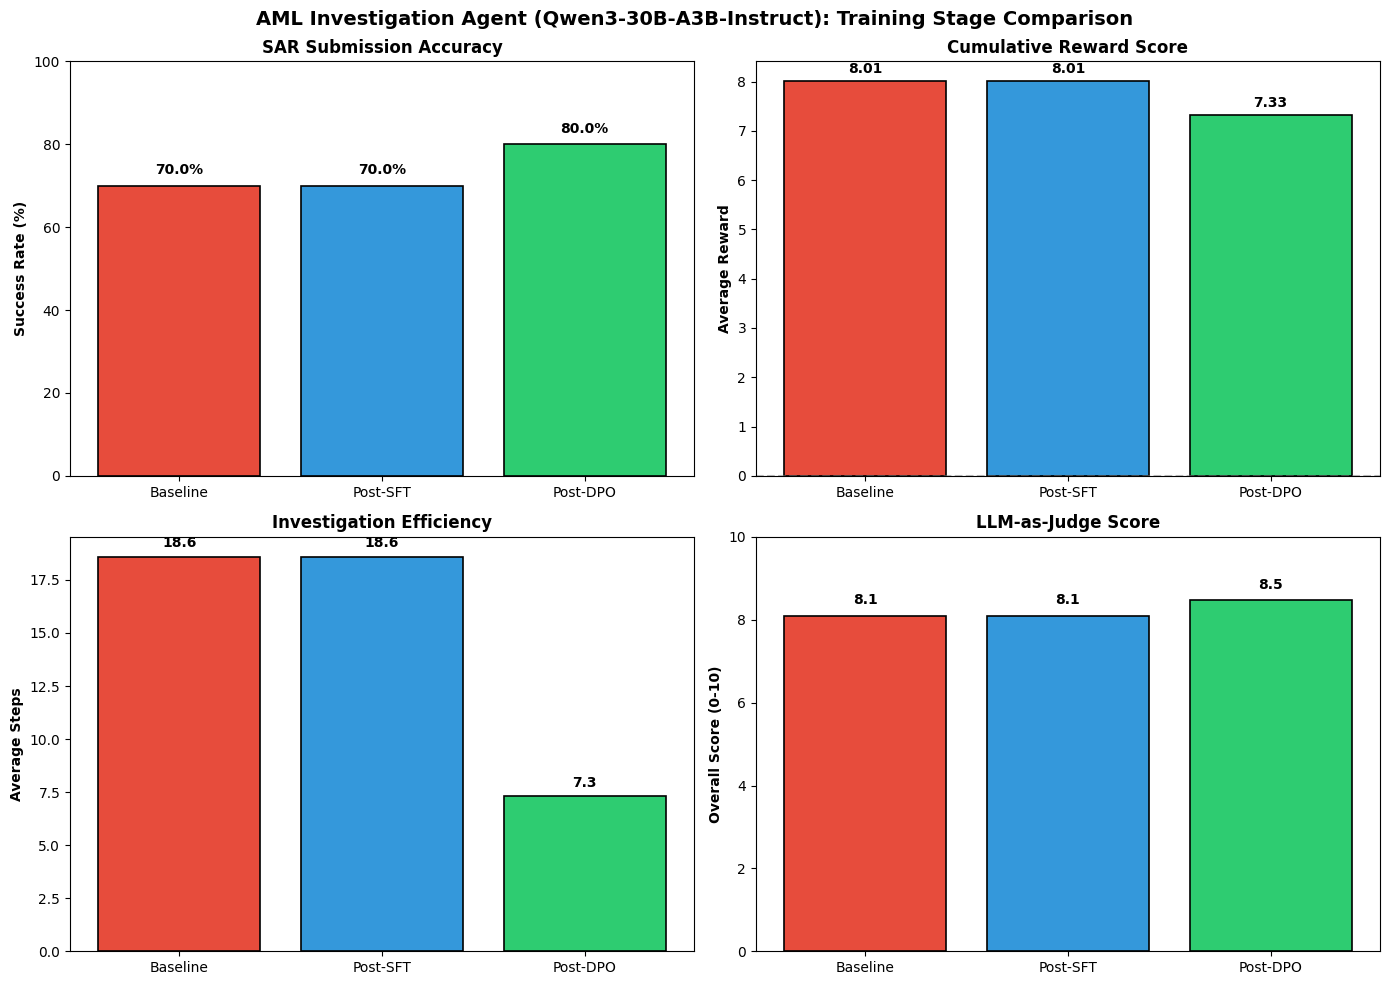

✓ Comparison chart saved to /workspace/outputs/training_comparison.png


In [23]:
# ============================================================================
# VISUALIZATION - Performance Comparison Charts
# ============================================================================

import matplotlib.pyplot as plt

# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('AML Investigation Agent (Qwen3-30B-A3B-Instruct): Training Stage Comparison', fontsize=14, fontweight='bold')

stages = list(all_results.keys())
# Colors: Baseline (red), SFT (blue), DPO (green)
colors = ['#e74c3c', '#3498db', '#2ecc71'][:len(stages)]

# 1. Success Rate
ax1 = axes[0, 0]
success_rates = [all_results[s]['success'].mean() * 100 for s in stages]
bars1 = ax1.bar(stages, success_rates, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Success Rate (%)', fontweight='bold')
ax1.set_title('SAR Submission Accuracy', fontweight='bold')
ax1.set_ylim(0, 100)
for bar, val in zip(bars1, success_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# 2. Average Reward
ax2 = axes[0, 1]
avg_rewards = [all_results[s]['total_reward'].mean() for s in stages]
bars2 = ax2.bar(stages, avg_rewards, color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Average Reward', fontweight='bold')
ax2.set_title('Cumulative Reward Score', fontweight='bold')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars2, avg_rewards):
    ypos = bar.get_height() + 0.1 if val >= 0 else bar.get_height() - 0.3
    ax2.text(bar.get_x() + bar.get_width()/2, ypos, f'{val:.2f}', 
             ha='center', va='bottom' if val >= 0 else 'top', fontweight='bold')

# 3. Average Steps
ax3 = axes[1, 0]
avg_steps = [all_results[s]['steps'].mean() for s in stages]
bars3 = ax3.bar(stages, avg_steps, color=colors, edgecolor='black', linewidth=1.2)
ax3.set_ylabel('Average Steps', fontweight='bold')
ax3.set_title('Investigation Efficiency', fontweight='bold')
for bar, val in zip(bars3, avg_steps):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{val:.1f}', 
             ha='center', va='bottom', fontweight='bold')

# 4. LLM-as-Judge Overall Score
ax4 = axes[1, 1]
if 'overall_score' in all_results[stages[0]].columns:
    overall_scores = [all_results[s]['overall_score'].mean() for s in stages]
    bars4 = ax4.bar(stages, overall_scores, color=colors, edgecolor='black', linewidth=1.2)
    ax4.set_ylabel('Overall Score (0-10)', fontweight='bold')
    ax4.set_title('LLM-as-Judge Score', fontweight='bold')
    ax4.set_ylim(0, 10)
    for bar, val in zip(bars4, overall_scores):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.1f}', 
                 ha='center', va='bottom', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'LLM-as-Judge\nNot Available', ha='center', va='center', fontsize=12)
    ax4.set_title('LLM-as-Judge Score', fontweight='bold')

plt.tight_layout()
comparison_chart_path = OUTPUT_DIR / "training_comparison.png"
plt.savefig(str(comparison_chart_path), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Comparison chart saved to {comparison_chart_path}")


---

## 15. Save Final Model

Save the trained model adapters for deployment.

**Saved Artifacts:**

| Path | Contents | Description |
|------|----------|-------------|
| `models/sft_adapter/` | LoRA weights + tokenizer | SFT-trained adapter (if SFT was run) |
| `models/dpo_adapter/` | LoRA weights + tokenizer | DPO-trained adapter (if DPO was run) |
| `models/aml_agent_final/` | Merged LoRA weights | Final model combining SFT + DPO adapters |
| `data/raw/dpo_dataset/` | JSON + pickle files | Cached DPO preference pairs for reuse |

**Loading the Final Model:**

```python
from unsloth import FastModel

model, tokenizer = FastModel.from_pretrained(
    "models/aml_agent_final",
    load_in_4bit=True,
)
```

**Deployment Notes:**
- The final model includes the tokenizer with Qwen3 Hermes-style tool calling configuration
- Use `apply_chat_template(..., tools=TOOLS)` for proper tool formatting
- The model is saved in 4-bit quantized format for efficient inference


In [24]:
# ============================================================================
# SAVE FINAL MODEL
# ============================================================================

# Determine what training was actually performed
skip_sft = globals().get('SKIP_SFT', False)
dpo_trained = 'dpo_adapter_path' in dir()

# Check if we have a trainable model with adapters
has_adapters = hasattr(model_for_training, 'peft_config') or hasattr(model_for_training, 'active_adapters')

print(f"\n{'=' * 60}")
print(f"💾 SAVING MODEL")
print(f"{'=' * 60}")
print(f"  SFT performed:    {'No' if skip_sft else 'Yes'}")
print(f"  DPO performed:    {'Yes' if dpo_trained else 'No'}")
print(f"  Has LoRA adapters: {'Yes' if has_adapters else 'No'}")

# Save final adapter to models directory (only if we have adapters)
final_model_path = MODELS_DIR / "aml_agent_final"
if has_adapters:
    model_for_training.save_pretrained(str(final_model_path))
    tokenizer.save_pretrained(str(final_model_path))
    print(f"  ✓ Model saved to: {final_model_path}")
else:
    # No training was done, just save tokenizer for reference
    tokenizer.save_pretrained(str(final_model_path))
    print(f"  ⚠️  No adapters to save (no training performed)")
    print(f"  ✓ Tokenizer saved to: {final_model_path}")

# Save comparison results
comparison_csv_path = OUTPUT_DIR / "training_comparison.csv"
comparison_df.to_csv(str(comparison_csv_path))

print(f"\n{'=' * 60}")
print(f"✅ TRAINING COMPLETE")
print(f"{'=' * 60}")
print(f"  Final Model:      {final_model_path}")

# Only print adapter paths if they exist
if 'sft_adapter_path' in dir() and not skip_sft:
    print(f"  SFT Adapter:      {sft_adapter_path}")
else:
    print(f"  SFT Adapter:      (skipped)")

# DPO adapter
if 'dpo_adapter_path' in dir():
    print(f"  DPO Adapter:      {dpo_adapter_path}")
else:
    print(f"  DPO Adapter:      (not trained)")

print(f"  Comparison Chart: {OUTPUT_DIR / 'training_comparison.png'}")
print(f"  Comparison CSV:   {comparison_csv_path}")
print(f"{'=' * 60}")

print(f"\n🎉 AML Investigation Agent (Qwen3-30B-A3B-Instruct) Training Complete!")
print(f"\n📊 Final Performance Summary:")
print(comparison_df.round(2).to_string())

print(f"\n🔧 Model Configuration:")
print(f"  Base Model:       {MODEL_NAME}")
print(f"  Architecture:     Mixture of Experts (MOE)")
print(f"  Tool Format:      Hermes-style <tool_call> tags")
print(f"  Quantization:     4-bit")

print(f"\nNext Steps:")
if has_adapters:
    print(f"  1. Load adapter with Unsloth FastModel for inference")
    print(f"  2. Deploy agent with custom orchestration")
    print(f"  3. Monitor with MLflow tracing")
else:
    print(f"  1. Use base model directly (no fine-tuning was needed)")
    print(f"  2. Deploy agent with custom orchestration")
    print(f"  3. Monitor with MLflow tracing")



💾 SAVING MODEL
  SFT performed:    No
  DPO performed:    Yes
  Has LoRA adapters: Yes
  ✓ Model saved to: /workspace/models/aml_agent_final

✅ TRAINING COMPLETE
  Final Model:      /workspace/models/aml_agent_final
  SFT Adapter:      (skipped)
  DPO Adapter:      /workspace/models/dpo_adapter
  Comparison Chart: /workspace/outputs/training_comparison.png
  Comparison CSV:   /workspace/outputs/training_comparison.csv

🎉 AML Investigation Agent (Qwen3-30B-A3B-Instruct) Training Complete!

📊 Final Performance Summary:
          Success Rate (%)  Avg Steps  Avg Reward  Avg Strategy Score  Avg Persistence Score  Avg Outcome Score  Avg Overall Score
Stage                                                                                                                             
Baseline              70.0       18.6        8.01                 8.1                    8.6                7.8               8.10
Post-SFT              70.0       18.6        8.01                 8.1              